## Necessary Imports

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, f1_score, recall_score, precision_score, classification_report, confusion_matrix, roc_auc_score)
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
import shap
import warnings
import time
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

## Function for creating the Dataset

In [15]:
def generate_credit_dataset(n_customers=25000, min_obs=1, max_obs=5, random_state=42):
  """
  Generates synthetic credit dataset with realistic patterns and relationships with 25000 people
  """
  np.random.seed(random_state)
  data = []
  customer_ids = [f"CUST_{i+1:06d}" for i in range(n_customers)]

  print(f"Generating dataset for {n_customers} customers...")

  for i, cust_id in enumerate(customer_ids):
    if i % 5000 == 0:
        print(f"Processing customer {i+1}/{n_customers}")

    n_months = np.random.randint(min_obs, max_obs + 1)

    # age, gender and location remain constant for a customer
    age = np.clip(np.random.normal(35, 12), 18, 70).astype(int)
    gender = np.random.choice(["M", "F", "Other"], p=[0.52, 0.46, 0.02])
    location = np.random.choice(
        ["Bangalore", "Mumbai", "Delhi", "Chennai", "Kolkata", "Pune", "Hyderabad"],
        p=[0.25, 0.20, 0.18, 0.12, 0.10, 0.08, 0.07]
    )

    # Base income influenced by age and location
    location_multiplier = {"Mumbai": 1.3, "Bangalore": 1.25, "Delhi": 1.2,
                          "Pune": 1.1, "Chennai": 1.0, "Hyderabad": 0.95, "Kolkata": 0.9}
    age_factor = 1 + (age - 25) * 0.02  # Income generally increases with age
    base_income = 30000 * location_multiplier[location] * age_factor

    for month in range(1, n_months + 1):
        # Monthly income with trend and seasonality with may increase in the bonus time or festive time
        seasonal_factor = 1 + 0.1 * np.sin(2 * np.pi * month / 12) # range is 0.9 to 1.1
        monthly_income = max(15000, np.random.lognormal(
            np.log(base_income * seasonal_factor), 0.3)) # 0.3 is the amount of spread, higher means more variation

        # EMI outflow - realistic debt-to-income ratios
        if age < 30:
            emi_ratio = np.random.beta(3, 4) * 0.6  # Younger people might have higher ratios spending more % of their income in EMIs
        else:
            emi_ratio = np.random.beta(4, 6) * 0.5  # Older people more conservative
        monthly_emi_outflow = monthly_income * emi_ratio

        # Outstanding debt with realistic patterns
        outstanding_months = np.random.randint(6, 36)
        current_outstanding = monthly_emi_outflow * outstanding_months * np.random.uniform(0.8, 1.2) # some may have paid early and some may have missed

        # Credit utilization - more realistic distribution
        credit_utilization_ratio = np.clip(np.random.beta(2, 5), 0, 1) # % of total credit being used

        # Number of loans - correlated with income and age
        loan_propensity = (monthly_income / 50000) + (age / 100)
        num_open_loans = np.random.poisson(max(0.5, min(3, loan_propensity)))

        # Repayment history - influenced by demographics
        if age > 40:
            repayment_base = 85  # Older people generally more responsible
        else:
            repayment_base = 75
        repayment_history_score = np.clip(
            np.random.normal(repayment_base, 15), 0, 100).astype(int)

        # Days past due - correlated with repayment score
        if repayment_history_score > 80:
            dpd_prob = 0.1
        elif repayment_history_score > 60:
            dpd_prob = 0.3
        else:
            dpd_prob = 0.6

        dpd_last_3_months = np.random.poisson(0.5) if np.random.rand() < dpd_prob else 0

        # Hard inquiries - more for younger people
        inquiry_rate = 2 if age < 30 else 1
        num_hard_inquiries_last_6m = np.random.poisson(inquiry_rate)

        # Credit card usage
        recent_credit_card_usage = np.clip(np.random.beta(2, 3), 0, 1)

        # Recent loan disbursement
        loan_prob = 0.15 if repayment_history_score > 70 else 0.05
        recent_loan_disbursed_amount = (monthly_income * np.random.uniform(0.5, 2.0)
                                      if np.random.rand() < loan_prob else 0)

        # Total credit limit - based on income and history
        credit_multiplier = 2 + (repayment_history_score / 100) * 2
        total_credit_limit = monthly_income * credit_multiplier * np.random.uniform(0.8, 1.2)

        # Months since last default
        if repayment_history_score > 85:
            months_since_last_default = 121  # Never defaulted
        else:
            default_prob = (100 - repayment_history_score) / 100 * 0.3
            if np.random.rand() < default_prob:
                months_since_last_default = np.random.randint(1, 60)
            else:
                months_since_last_default = 121

        data.append([
            cust_id, age, gender, location, monthly_income, monthly_emi_outflow,
            current_outstanding, credit_utilization_ratio, num_open_loans,
            repayment_history_score, dpd_last_3_months, num_hard_inquiries_last_6m,
            recent_credit_card_usage, recent_loan_disbursed_amount, total_credit_limit,
            months_since_last_default
        ])

  # Create DataFrame
  df = pd.DataFrame(data, columns=[
      "customer_id", "age", "gender", "location", "monthly_income", "monthly_emi_outflow",
      "current_outstanding", "credit_utilization_ratio", "num_open_loans",
      "repayment_history_score", "dpd_last_3_months", "num_hard_inquiries_last_6m",
      "recent_credit_card_usage", "recent_loan_disbursed_amount", "total_credit_limit",
      "months_since_last_default"
  ])

  print(f"Generated dataset with {len(df)} rows")

  def calculate_target_advanced(row):
    """Enhanced target calculation with more realistic business logic"""

    # Calculate component scores
    payment_behavior = (
        -2.0 * min(1, row['dpd_last_3_months'] / 30)  # Penalty for late payments
        + 1.5 * (row['repayment_history_score'] / 100)  # Reward good history
    )

    credit_utilization = -1.5 * row['credit_utilization_ratio']  # High utilization is bad

    debt_burden = -1.0 * min(1, row['monthly_emi_outflow'] / row['monthly_income'])

    credit_seeking = -0.5 * min(1, row['num_hard_inquiries_last_6m'] / 5)

    stability = (
        0.3 * min(1, row['age'] / 50)  # Age stability
        + 0.2 * (1 if row['months_since_last_default'] > 120 else
                max(0, row['months_since_last_default'] / 120))
    )

    # Recent credit activity
    recent_activity = -0.3 * (row['recent_loan_disbursed_amount'] /
                              max(row['monthly_income'], 1000))

    # Calculate final score
    final_score = (payment_behavior + credit_utilization + debt_burden +
                  credit_seeking + stability + recent_activity)

    # Add controlled noise
    noisy_score = final_score + np.random.normal(0, 0.15)

    # Classify with balanced thresholds
    if noisy_score < -0.3:
        return "decrease"
    elif noisy_score > 0.3:
        return "increase"
    else:
        return "stable"

  df['target_credit_score_movement'] = df.apply(calculate_target_advanced, axis=1)

  # Display class distribution
  print("\nTarget Distribution:")
  print(df['target_credit_score_movement'].value_counts())
  print(f"Target Distribution (%):")
  print(df['target_credit_score_movement'].value_counts(normalize=True) * 100)

  return df

## Function for EDA

In [16]:
def perform_comprehensive_eda(df):
    """
    Comprehensive Exploratory Data Analysis
    """
    print("="*80)
    print("COMPREHENSIVE EXPLORATORY DATA ANALYSIS")
    print("="*80)

    # ==============================
    # SECTION 1: BASIC DATA OVERVIEW
    # ==============================
    print(f"\nBASIC DATA OVERVIEW:")
    print(f"   Dataset Shape: {df.shape}")
    print(f"   Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    print(f"   Total Customers: {df['customer_id'].nunique():,}")

    # Missing values analysis
    print(f"\nDATA QUALITY ASSESSMENT:")
    missing = df.isnull().sum()
    if missing.sum() == 0:
        print("No missing values found")
    else:
        print("Missing values detected:")
        for col, count in missing[missing > 0].items():
            print(f"      {col}: {count} ({count/len(df)*100:.1f}%)")

    print(f"\nDATA TYPES:")
    for dtype_group in df.dtypes.value_counts().items():
        print(f"   {dtype_group[0]}: {dtype_group[1]} columns")

    # Statistical summary with business context
    print(f"\nSTATISTICAL SUMMARY:")
    desc_stats = df.describe()
    print(desc_stats.round(2))

    # ==============================
    # SECTION 2: TARGET ANALYSIS & CORE DISTRIBUTIONS
    # ==============================
    fig1, axes1 = plt.subplots(2, 3, figsize=(22, 14))
    fig1.suptitle('Credit Risk - Target Analysis & Core Distributions', fontsize=16, fontweight='bold')

    # Target distribution with risk context
    target_counts = df['target_credit_score_movement'].value_counts()
    colors = ['red' if x == 'decrease' else 'green' if x == 'increase' else 'gold' for x in target_counts.index]
    wedges, texts, autotexts = axes1[0,0].pie(target_counts.values, labels=target_counts.index,
                                              autopct='%1.1f%%', colors=colors, startangle=90)
    axes1[0,0].set_title('Portfolio Risk Distribution\n(Credit Score Movement)', fontweight='bold')

    # Age distribution with risk overlay
    for target in df['target_credit_score_movement'].unique():
        subset = df[df['target_credit_score_movement'] == target]
        color = 'red' if target == 'decrease' else 'green' if target == 'increase' else 'gold'
        axes1[0,1].hist(subset['age'], alpha=0.7, label=target, bins=20, color=color, edgecolor='black')
    axes1[0,1].set_title('Age Distribution by Risk Category', fontweight='bold')
    axes1[0,1].set_xlabel('Age')
    axes1[0,1].set_ylabel('Frequency')
    axes1[0,1].legend()
    axes1[0,1].grid(True, alpha=0.3)

    # Income vs EMI with risk zones
    scatter_colors = {'decrease': 'red', 'stable': 'gold', 'increase': 'green'}
    for target in df['target_credit_score_movement'].unique():
        subset = df[df['target_credit_score_movement'] == target]
        axes1[0,2].scatter(subset['monthly_income'], subset['monthly_emi_outflow'],
                          alpha=0.6, label=target, c=scatter_colors[target], s=3, edgecolors='black', linewidth=0.1)

    # Add risk zone lines
    max_income = df['monthly_income'].max()
    risk_line_x = np.linspace(df['monthly_income'].min(), max_income, 100)
    risk_line_40 = risk_line_x * 0.4  # 40% DTI risk threshold
    risk_line_60 = risk_line_x * 0.6  # 60% DTI high risk threshold

    axes1[0,2].plot(risk_line_x, risk_line_40, 'orange', linestyle='--', alpha=0.8, label='40% DTI Risk Line')
    axes1[0,2].plot(risk_line_x, risk_line_60, 'red', linestyle='--', alpha=0.8, label='60% DTI High Risk')
    axes1[0,2].set_title('Income vs EMI with Risk Zones', fontweight='bold')
    axes1[0,2].set_xlabel('Monthly Income (₹)')
    axes1[0,2].set_ylabel('Monthly EMI (₹)')
    axes1[0,2].legend()
    axes1[0,2].grid(True, alpha=0.3)

    # Credit utilization with risk thresholds
    for target in df['target_credit_score_movement'].unique():
        subset = df[df['target_credit_score_movement'] == target]
        color = scatter_colors[target]
        axes1[1,0].hist(subset['credit_utilization_ratio'], alpha=0.7, label=target,
                       bins=30, color=color, edgecolor='black')
    axes1[1,0].axvline(0.3, color='orange', linestyle='--', alpha=0.8, label='30% (Optimal)')
    axes1[1,0].axvline(0.8, color='red', linestyle='--', alpha=0.8, label='80% (High Risk)')
    axes1[1,0].set_title('Credit Utilization Distribution', fontweight='bold')
    axes1[1,0].set_xlabel('Credit Utilization Ratio')
    axes1[1,0].set_ylabel('Frequency')
    axes1[1,0].legend()
    axes1[1,0].grid(True, alpha=0.3)

    # Repayment score distribution with credit quality zones
    for target in df['target_credit_score_movement'].unique():
        subset = df[df['target_credit_score_movement'] == target]
        color = scatter_colors[target]
        axes1[1,1].hist(subset['repayment_history_score'], alpha=0.7, label=target,
                       bins=25, color=color, edgecolor='black')
    axes1[1,1].axvline(60, color='red', linestyle='--', alpha=0.8, label='Poor Credit (60)')
    axes1[1,1].axvline(80, color='orange', linestyle='--', alpha=0.8, label='Good Credit (80)')
    axes1[1,1].set_title('Repayment Score Distribution', fontweight='bold')
    axes1[1,1].set_xlabel('Repayment History Score')
    axes1[1,1].set_ylabel('Frequency')
    axes1[1,1].legend()
    axes1[1,1].grid(True, alpha=0.3)

    # Geographic risk distribution
    location_target = pd.crosstab(df['location'], df['target_credit_score_movement'])
    location_target_pct = location_target.div(location_target.sum(axis=1), axis=0) * 100
    location_target_pct.plot(kind='bar', ax=axes1[1,2], stacked=True,
                            color=['red', 'green', 'gold'])
    axes1[1,2].set_title('Geographic Risk Distribution (%)', fontweight='bold')
    axes1[1,2].set_xlabel('Location')
    axes1[1,2].set_ylabel('Percentage')
    axes1[1,2].tick_params(axis='x', rotation=45)
    axes1[1,2].legend(title='Risk Category')
    axes1[1,2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # ==============================
    # SECTION 3: CRITICAL RISK INDICATORS ANALYSIS
    # ==============================
    # Create engineered risk features for analysis
    df_risk = df.copy()
    df_risk['debt_to_income_ratio'] = df_risk['monthly_emi_outflow'] / df_risk['monthly_income']
    df_risk['credit_limit_utilization'] = df_risk['current_outstanding'] / df_risk['total_credit_limit']

    fig2, axes2 = plt.subplots(2, 4, figsize=(24, 12))
    fig2.suptitle('Critical Risk Indicators Analysis', fontsize=16, fontweight='bold')

    # 1. DPD Distribution (Critical for risk assessment)
    axes2[0,0].hist(df['dpd_last_3_months'], bins=max(15, df['dpd_last_3_months'].nunique()),
                   alpha=0.7, color='red', edgecolor='black')
    axes2[0,0].axvline(df['dpd_last_3_months'].mean(), color='blue', linestyle='--',
                      label=f'Mean: {df["dpd_last_3_months"].mean():.1f}')
    axes2[0,0].axvline(30, color='orange', linestyle='--', label='30 Days (Risk Threshold)')
    axes2[0,0].set_title('Days Past Due Distribution', fontweight='bold')
    axes2[0,0].set_xlabel('DPD Last 3 Months')
    axes2[0,0].set_ylabel('Frequency')
    axes2[0,0].legend()
    axes2[0,0].grid(True, alpha=0.3)

    # 2. Debt-to-Income Ratio Analysis
    axes2[0,1].hist(df_risk['debt_to_income_ratio'], bins=30, alpha=0.7, color='orange', edgecolor='black')
    axes2[0,1].axvline(0.4, color='red', linestyle='--', label='High Risk (40%)')
    axes2[0,1].axvline(0.6, color='darkred', linestyle='--', label='Critical Risk (60%)')
    axes2[0,1].axvline(df_risk['debt_to_income_ratio'].median(), color='blue', linestyle='--',
                      label=f'Median: {df_risk["debt_to_income_ratio"].median():.2f}')
    axes2[0,1].set_title('Debt-to-Income Ratio Distribution', fontweight='bold')
    axes2[0,1].set_xlabel('DTI Ratio')
    axes2[0,1].set_ylabel('Frequency')
    axes2[0,1].legend()
    axes2[0,1].grid(True, alpha=0.3)

    # 3. Default History Analysis
    default_counts = (df['months_since_last_default'] <= 120).value_counts()
    default_labels = ['Never Defaulted', 'Has Default History']
    default_colors = ['green', 'red']
    axes2[0,2].pie(default_counts.values, labels=default_labels, autopct='%1.1f%%',
                  colors=default_colors, startangle=90)
    axes2[0,2].set_title('Portfolio Default History', fontweight='bold')

    # 4. Hard Inquiries vs Target
    inquiry_target = pd.crosstab(df['num_hard_inquiries_last_6m'], df['target_credit_score_movement'])
    inquiry_target.plot(kind='bar', ax=axes2[0,3], color=['red', 'green', 'gold'])
    axes2[0,3].set_title('Credit Inquiries vs Risk', fontweight='bold')
    axes2[0,3].set_xlabel('Number of Hard Inquiries (6M)')
    axes2[0,3].set_ylabel('Count')
    axes2[0,3].tick_params(axis='x', rotation=0)
    axes2[0,3].legend(title='Risk Category')
    axes2[0,3].grid(True, alpha=0.3)

    # 5. Income Distribution by Risk Segments
    risk_segments = pd.cut(df['credit_utilization_ratio'],
                          bins=[0, 0.3, 0.7, 1.0],
                          labels=['Low Risk', 'Medium Risk', 'High Risk'])
    df_risk['risk_segment'] = risk_segments

    for segment in ['Low Risk', 'Medium Risk', 'High Risk']:
        if segment in df_risk['risk_segment'].values:
            subset = df_risk[df_risk['risk_segment'] == segment]
            color = 'green' if segment == 'Low Risk' else 'orange' if segment == 'Medium Risk' else 'red'
            axes2[1,0].hist(subset['monthly_income'], alpha=0.6, label=segment,
                           bins=20, color=color, edgecolor='black')
    axes2[1,0].set_title('Income Distribution by Risk Segment', fontweight='bold')
    axes2[1,0].set_xlabel('Monthly Income (₹)')
    axes2[1,0].set_ylabel('Frequency')
    axes2[1,0].legend()
    axes2[1,0].grid(True, alpha=0.3)

    # 6. Repayment Score vs DPD Correlation
    for target in df['target_credit_score_movement'].unique():
        subset = df[df['target_credit_score_movement'] == target]
        color = scatter_colors[target]
        axes2[1,1].scatter(subset['repayment_history_score'], subset['dpd_last_3_months'],
                          alpha=0.6, label=target, c=color, s=2, edgecolors='black', linewidth=0.1)
    axes2[1,1].set_title('Repayment Score vs DPD Risk Matrix', fontweight='bold')
    axes2[1,1].set_xlabel('Repayment History Score')
    axes2[1,1].set_ylabel('DPD Last 3 Months')
    axes2[1,1].legend()
    axes2[1,1].grid(True, alpha=0.3)

    # 7. Age vs Risk Profile
    age_risk = pd.crosstab(pd.cut(df['age'], bins=[0, 25, 35, 45, 55, 100],
                                 labels=['18-25', '26-35', '36-45', '46-55', '56+']),
                          df['target_credit_score_movement'])
    age_risk_pct = age_risk.div(age_risk.sum(axis=1), axis=0) * 100
    age_risk_pct.plot(kind='bar', ax=axes2[1,2], stacked=True, color=['red', 'green', 'gold'])
    axes2[1,2].set_title('Age Group Risk Profile (%)', fontweight='bold')
    axes2[1,2].set_xlabel('Age Group')
    axes2[1,2].set_ylabel('Percentage')
    axes2[1,2].tick_params(axis='x', rotation=45)
    axes2[1,2].legend(title='Risk Category')
    axes2[1,2].grid(True, alpha=0.3)

    # 8. Portfolio Risk Concentration
    # Create business risk score
    df_risk['business_risk_score'] = (
        (df['dpd_last_3_months'] > 30).astype(int) * 3 +
        (df['credit_utilization_ratio'] > 0.8).astype(int) * 2 +
        (df['repayment_history_score'] < 60).astype(int) * 2 +
        (df['num_hard_inquiries_last_6m'] > 3).astype(int) * 1
    )

    df_risk['risk_category'] = pd.cut(df_risk['business_risk_score'],
                                     bins=[-1, 0, 2, 4, 8],
                                     labels=['Low Risk', 'Medium Risk', 'High Risk', 'Critical Risk'])

    risk_dist = df_risk['risk_category'].value_counts()
    risk_colors = ['green', 'yellow', 'orange', 'red']
    axes2[1,3].pie(risk_dist.values, labels=risk_dist.index, autopct='%1.1f%%',
                  colors=risk_colors[:len(risk_dist)], startangle=90)
    axes2[1,3].set_title('Business Risk Category Distribution', fontweight='bold')

    plt.tight_layout()
    plt.show()

    # ==============================
    # SECTION 4: OUTLIER DETECTION ANALYSIS
    # ==============================
    print("\nOUTLIER DETECTION ANALYSIS:")
    print("-" * 40)

    fig3, axes3 = plt.subplots(2, 3, figsize=(20, 12))
    fig3.suptitle('Outlier Detection Analysis', fontsize=16, fontweight='bold')

    key_risk_vars = ['monthly_income', 'monthly_emi_outflow', 'credit_utilization_ratio',
                     'repayment_history_score', 'dpd_last_3_months', 'current_outstanding']

    for i, var in enumerate(key_risk_vars):
        row, col = i // 3, i % 3

        # Boxplot with target coloring
        box_data = [df[df['target_credit_score_movement'] == target][var]
                   for target in ['decrease', 'stable', 'increase']]

        box = axes3[row, col].boxplot(box_data, labels=['Decrease', 'Stable', 'Increase'],
                                     patch_artist=True)

        # Color boxes by risk level
        colors = ['red', 'gold', 'green']
        for patch, color in zip(box['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)

        axes3[row, col].set_title(f'{var.replace("_", " ").title()} by Target', fontweight='bold')
        axes3[row, col].grid(True, alpha=0.3)

        # Calculate and display outlier statistics
        Q1 = df[var].quantile(0.25)
        Q3 = df[var].quantile(0.75)
        IQR = Q3 - Q1
        outliers = df[(df[var] < (Q1 - 1.5 * IQR)) | (df[var] > (Q3 + 1.5 * IQR))]
        outlier_pct = len(outliers) / len(df) * 100

        axes3[row, col].text(0.02, 0.98, f'Outliers: {outlier_pct:.1f}%',
                            transform=axes3[row, col].transAxes,
                            verticalalignment='top',
                            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()

    # ==============================
    # SECTION 5: ADVANCED CORRELATION ANALYSIS
    # ==============================
    print("\n" + "="*60)
    print("ADVANCED CORRELATION ANALYSIS")
    print("="*60)

    # Encode categorical variables for correlation
    df_corr = df.copy()
    le = LabelEncoder()
    df_corr['gender_encoded'] = le.fit_transform(df_corr['gender'])
    df_corr['location_encoded'] = le.fit_transform(df_corr['location'])
    df_corr['target_encoded'] = le.fit_transform(df_corr['target_credit_score_movement'])

    # Add engineered features to correlation analysis
    df_corr['debt_to_income_ratio'] = df_corr['monthly_emi_outflow'] / df_corr['monthly_income']
    df_corr['credit_limit_utilization'] = df_corr['current_outstanding'] / df_corr['total_credit_limit']

    # Select numeric columns for correlation
    numeric_cols = ['age', 'monthly_income', 'monthly_emi_outflow', 'current_outstanding',
                   'credit_utilization_ratio', 'num_open_loans', 'repayment_history_score',
                   'dpd_last_3_months', 'num_hard_inquiries_last_6m', 'recent_credit_card_usage',
                   'recent_loan_disbursed_amount', 'total_credit_limit', 'months_since_last_default',
                   'debt_to_income_ratio', 'credit_limit_utilization',
                   'gender_encoded', 'location_encoded', 'target_encoded']

    # Handle any infinite or NaN values
    df_corr[numeric_cols] = df_corr[numeric_cols].replace([np.inf, -np.inf], np.nan)
    df_corr[numeric_cols] = df_corr[numeric_cols].fillna(df_corr[numeric_cols].median())

    corr_matrix = df_corr[numeric_cols].corr()

    # Enhanced correlation heatmap
    fig4, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))

    # Full correlation matrix
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
                square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, fmt='.2f',
                ax=ax1)
    ax1.set_title('Complete Feature Correlation Matrix', fontweight='bold', fontsize=14)

    # Target-specific correlation
    target_corr = corr_matrix['target_encoded'].abs().sort_values(ascending=True)
    target_corr_filtered = target_corr[target_corr.index != 'target_encoded']

    # Create horizontal bar plot for target correlations
    colors = ['red' if x < 0.05 else 'orange' if x < 0.1 else 'green' for x in target_corr_filtered.values]
    bars = ax2.barh(range(len(target_corr_filtered)), target_corr_filtered.values, color=colors, alpha=0.7)
    ax2.set_yticks(range(len(target_corr_filtered)))
    ax2.set_yticklabels([name.replace('_', ' ').title() for name in target_corr_filtered.index], fontsize=10)
    ax2.set_xlabel('Absolute Correlation with Target', fontsize=12)
    ax2.set_title('Feature Importance by Target Correlation', fontweight='bold', fontsize=14)
    ax2.grid(True, alpha=0.3)

    # Add correlation strength indicators
    ax2.axvline(0.1, color='orange', linestyle='--', alpha=0.8, label='Moderate (0.1)')
    ax2.axvline(0.2, color='green', linestyle='--', alpha=0.8, label='Strong (0.2)')
    ax2.legend()

    plt.tight_layout()
    plt.show()

    return df_corr, corr_matrix, target_corr_filtered


## Function for Feature Engineering

In [17]:
def engineer_features(df):
    """Create additional features based on domain knowledge"""
    df_eng = df.copy()

    # Debt-to-Income ratio
    df_eng['debt_to_income_ratio'] = df_eng['monthly_emi_outflow'] / df_eng['monthly_income']

    # Credit limit utilization
    df_eng['credit_limit_utilization'] = df_eng['current_outstanding'] / df_eng['total_credit_limit']

    # Income stability indicator (higher income usually more stable)
    df_eng['income_bracket'] = pd.cut(df_eng['monthly_income'],
                                     bins=[0, 30000, 50000, 80000, float('inf')],
                                     labels=['Low', 'Medium', 'High', 'Very High'])

    # Age groups
    df_eng['age_group'] = pd.cut(df_eng['age'],
                                bins=[0, 25, 35, 45, 55, float('inf')],
                                labels=['Young', 'Early Career', 'Mid Career', 'Senior', 'Retirement'])

    # Risk indicators
    df_eng['high_risk_indicator'] = (
        (df_eng['dpd_last_3_months'] > 30) |
        (df_eng['credit_utilization_ratio'] > 0.8) |
        (df_eng['debt_to_income_ratio'] > 0.5)
    ).astype(int)

    # Recent credit activity score
    df_eng['recent_activity_score'] = (
        df_eng['num_hard_inquiries_last_6m'] * 0.3 +
        (df_eng['recent_loan_disbursed_amount'] / df_eng['monthly_income']) * 0.7
    )

    print(f"Engineering complete. Added {len(df_eng.columns) - len(df.columns)} new features")
    return df_eng

## Function for Preprocessing

In [18]:
def advanced_preprocessing_pipeline(X_train, X_test, strategy='balanced'):
    """Preprocessing with multiple strategies"""

    # Identify feature types
    numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

    print(f"Numeric features ({len(numeric_features)}): {numeric_features}")
    print(f"Categorical features ({len(categorical_features)}): {categorical_features}")

    # Create preprocessing pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
        ],
        remainder='passthrough'
    )

    # Fit and transform
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)

    # Get feature names after preprocessing
    feature_names = (numeric_features +
                    list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)))

    return X_train_processed, X_test_processed, preprocessor, feature_names

## Function to handle Class Imbalance

In [19]:
def handle_class_imbalance(X_train, y_train, strategy='smote_tomek'):
    """Multiple strategies for handling class imbalance"""

    print(f"Original class distribution:")
    print(pd.Series(y_train).value_counts())

    if strategy == 'smote':
        sampler = SMOTE(random_state=42)
    elif strategy == 'adasyn':
        sampler = ADASYN(random_state=42)
    elif strategy == 'smote_tomek':
        sampler = SMOTETomek(random_state=42)
    elif strategy == 'undersample':
        sampler = RandomUnderSampler(random_state=42)
    else:
        return X_train, y_train

    X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)

    print(f"Resampled class distribution ({strategy}):")
    print(pd.Series(y_resampled).value_counts())

    return X_resampled, y_resampled

## Function to Train Models

In [20]:
def train_multiple_models_optimized(X_train, y_train, X_test, y_test, feature_names):
    """Model training with detailed progress visualization and comprehensive time logging"""

    models = {
        'Random Forest': RandomForestClassifier(random_state=42),
        'Hist Gradient Boosting': HistGradientBoostingClassifier(random_state=42),
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
    }

    param_grids = {
        'Random Forest': {
            'n_estimators': [100, 200],
            'max_depth': [10, None],
            'min_samples_split': [2, 5],
            'class_weight': ['balanced']
        },
        'Hist Gradient Boosting': {
            'learning_rate': [0.1, 0.15],
            'max_depth': [3, 5],
            'max_iter': [100, 150],
            'early_stopping': [True],
            'validation_fraction': [0.1],
            'n_iter_no_change': [10],
            'class_weight': ['balanced']
        },
        'Logistic Regression': {
            'C': [1, 10],
            'class_weight': ['balanced'],
        }
    }

    results = {}
    best_models = {}
    timing_summary = {}  # Store detailed timing information

    # Overall pipeline start time
    pipeline_start_time = time.time()

    # Main progress bar for models
    model_progress = tqdm(models.items(),
                         desc="Training Models",
                         unit="model",
                         colour='green',
                         bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]')

    for name, model in model_progress:
        # Start timing for individual model
        model_start_time = time.time()
        model_progress.set_description(f"Training {name}")

        # Initialize timing dictionary for this model
        model_timings = {
            'hyperparameter_tuning_time': 0,
            'evaluation_time': 0,
            'total_model_time': 0
        }

        # Hyperparameter tuning progress
        total_combinations = min(20, len(list(param_grids[name].keys())))

        with tqdm(total=total_combinations,
                 desc=f"Hyperparameter Tuning",
                 leave=False,
                 colour='blue',
                 unit="combination") as hp_progress:

            # Hyperparameter search with detailed timing
            hp_start_time = time.time()

            search = RandomizedSearchCV(
                model,
                param_grids[name],
                n_iter=6,
                cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                scoring='f1_macro',
                random_state=42,
                n_jobs=-1,
                verbose=0
            )

            # Fit the model with timing
            search.fit(X_train, y_train)

            hp_end_time = time.time()
            model_timings['hyperparameter_tuning_time'] = hp_end_time - hp_start_time

            # Update progress bar to completion with timing info
            hp_progress.update(total_combinations - hp_progress.n)
            hp_progress.set_postfix({
                'Time': f"{model_timings['hyperparameter_tuning_time']:.1f}s",
                'Best Score': f"{search.best_score_:.4f}"
            })

        best_model = search.best_estimator_
        best_models[name] = best_model

        # Model evaluation progress with timing
        eval_start_time = time.time()

        with tqdm(total=4,
                 desc=f"Evaluating {name}",
                 leave=False,
                 colour='yellow',
                 unit="metric") as eval_progress:

            # Predictions
            eval_progress.set_postfix_str("Making predictions...")
            pred_start = time.time()
            y_pred = best_model.predict(X_test)
            pred_time = time.time() - pred_start
            eval_progress.update(1)

            # Probability predictions
            eval_progress.set_postfix_str("Computing probabilities...")
            proba_start = time.time()
            y_pred_proba = best_model.predict_proba(X_test)
            proba_time = time.time() - proba_start
            eval_progress.update(1)

            # Calculate metrics
            eval_progress.set_postfix_str("Computing metrics...")
            metrics_start = time.time()
            accuracy = accuracy_score(y_test, y_pred)
            f1_macro = f1_score(y_test, y_pred, average='macro')
            f1_weighted = f1_score(y_test, y_pred, average='weighted')
            metrics_time = time.time() - metrics_start
            eval_progress.update(1)

            # AUC calculation
            eval_progress.set_postfix_str("Computing AUC...")
            auc_start = time.time()
            try:
                auc_score = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro')
            except:
                auc_score = np.nan
            auc_time = time.time() - auc_start
            eval_progress.update(1)

        eval_end_time = time.time()
        model_timings['evaluation_time'] = eval_end_time - eval_start_time

        # Calculate total model time
        model_end_time = time.time()
        model_timings['total_model_time'] = model_end_time - model_start_time

        # Add detailed sub-timings
        model_timings.update({
            'prediction_time': pred_time,
            'probability_time': proba_time,
            'metrics_calculation_time': metrics_time,
            'auc_calculation_time': auc_time
        })

        # Store results with comprehensive timing information
        results[name] = {
            'model': best_model,
            'best_params': search.best_params_,
            'best_cv_score': search.best_score_,
            'accuracy': accuracy,
            'f1_macro': f1_macro,
            'f1_weighted': f1_weighted,
            'auc_score': auc_score,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba,
            'timings': model_timings  # Add timing information to results
        }

        # Store timing summary for final report
        timing_summary[name] = model_timings

        # Update main progress bar with performance and timing info
        model_progress.set_postfix({
            'F1': f"{f1_macro:.4f}",
            'Acc': f"{accuracy:.4f}",
            'Time': f"{model_timings['total_model_time']:.1f}s"
        })

        # Print detailed timing for each completed model
        print(f"\n{name} Training Completed:")
        print(f"   --> Hyperparameter Tuning: {model_timings['hyperparameter_tuning_time']:.2f}s")
        print(f"   --> Model Evaluation: {model_timings['evaluation_time']:.2f}s")
        print(f"   --> Total Training Time: {model_timings['total_model_time']:.2f}s")
        print(f"   --> Performance: F1={f1_macro:.4f}, Accuracy={accuracy:.4f}")

    model_progress.close()

    # Calculate total pipeline time
    pipeline_end_time = time.time()
    total_pipeline_time = pipeline_end_time - pipeline_start_time

    # Comprehensive Timing Summary
    print("\n" + "="*80)
    print("COMPREHENSIVE TRAINING TIME ANALYSIS")
    print("="*80)

    # Create timing comparison DataFrame
    timing_df = pd.DataFrame({
        'Model': list(timing_summary.keys()),
        'Hyperparameter_Tuning_Time_(s)': [t['hyperparameter_tuning_time'] for t in timing_summary.values()],
        'Evaluation_Time_(s)': [t['evaluation_time'] for t in timing_summary.values()],
        'Total_Training_Time_(s)': [t['total_model_time'] for t in timing_summary.values()],
        'F1_Score': [results[name]['f1_macro'] for name in timing_summary.keys()],
        'Accuracy': [results[name]['accuracy'] for name in timing_summary.keys()]
    })

    # Sort by training time
    timing_df = timing_df.sort_values('Total_Training_Time_(s)')

    print("Training Time Comparison:")
    print(timing_df.round(2))

    # Time efficiency analysis
    print(f"\nTime Efficiency Analysis:")
    fastest_model = timing_df.iloc[0]['Model']
    slowest_model = timing_df.iloc[-1]['Model']
    fastest_time = timing_df.iloc[0]['Total_Training_Time_(s)']
    slowest_time = timing_df.iloc[-1]['Total_Training_Time_(s)']

    print(f"   --> Fastest Model: {fastest_model} ({fastest_time:.2f}s)")
    print(f"   --> Slowest Model: {slowest_model} ({slowest_time:.2f}s)")
    print(f"   --> Speed Difference: {slowest_time/fastest_time:.1f}x slower")
    print(f"   --> Total Pipeline Time: {total_pipeline_time:.2f}s")

    # Performance vs Time analysis
    print(f"\nPerformance vs Time Analysis:")
    for _, row in timing_df.iterrows():
        efficiency_score = row['F1_Score'] / (row['Total_Training_Time_(s)'] / 60)  # F1 per minute
        print(f"   -> {row['Model']}: {efficiency_score:.3f} F1/minute")

    # Best model recommendation based on performance and time
    timing_df['efficiency_score'] = timing_df['F1_Score'] / (timing_df['Total_Training_Time_(s)'] / 60)
    best_efficient_model = timing_df.loc[timing_df['efficiency_score'].idxmax(), 'Model']

    print(f"\nRecommendations:")
    print(f"   --> Best Performance: {timing_df.loc[timing_df['F1_Score'].idxmax(), 'Model']}")
    print(f"   --> Fastest Training: {fastest_model}")
    print(f"   --> Best Efficiency (F1/time): {best_efficient_model}")

    pipeline_summary = {
        'total_pipeline_time': total_pipeline_time,
        'model_timings': timing_summary,
        'timing_comparison': timing_df,
        'recommendations': {
            'fastest_model': fastest_model,
            'most_efficient_model': best_efficient_model,
            'speed_advantage': f"{slowest_time/fastest_time:.1f}x"
        }
    }

    return results, best_models, pipeline_summary


## Function for Comprehensive Evaluation

In [21]:
def comprehensive_evaluation(results, y_test, class_names):
    """Comprehensive model evaluation and comparison"""

    print("\n" + "="*60)
    print("COMPREHENSIVE MODEL EVALUATION")
    print("="*60)

    # Summary table
    summary_df = pd.DataFrame({
        name: {
            'Accuracy': result['accuracy'],
            'F1 Macro': result['f1_macro'],
            'F1 Weighted': result['f1_weighted'],
            'AUC Macro': result['auc_score']
        }
        for name, result in results.items()
    }).T

    print("\nModel Performance Summary:")
    print(summary_df.round(4))

    # Detailed classification reports
    for name, result in results.items():
        print(f"\n{name} - Detailed Classification Report:")
        print(classification_report(y_test, result['y_pred'], target_names=class_names))

    # Confusion matrices
    fig, axes = plt.subplots(1, len(results), figsize=(5*len(results), 4))
    if len(results) == 1:
        axes = [axes]

    for idx, (name, result) in enumerate(results.items()):
        cm = confusion_matrix(y_test, result['y_pred'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=class_names, yticklabels=class_names, ax=axes[idx])
        axes[idx].set_title(f'{name}\nConfusion Matrix')
        axes[idx].set_xlabel('Predicted')
        axes[idx].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

    return summary_df

## Function for Shap Analysis

In [22]:
def shap_analysis(model, X_test, feature_names, model_name="Model"):
    """Comprehensive SHAP analysis with proper array length handling"""

    print(f"\n" + "="*60)
    print(f"SHAP ANALYSIS FOR {model_name.upper()}")
    print("="*60)

    # Debug: Print initial information
    print(f"Initial feature_names length: {len(feature_names)}")
    print(f"X_test shape: {X_test.shape}")

    # Create explainer with proper error handling
    try:
        if isinstance(model, (RandomForestClassifier, HistGradientBoostingClassifier)):
            print("Using TreeExplainer...")
            explainer = shap.TreeExplainer(model)
        elif isinstance(model, LogisticRegression):
            print("Using LinearExplainer...")
            # Use a smaller background sample for LinearExplainer
            background_sample = X_test[np.random.choice(X_test.shape[0], min(50, X_test.shape[0]), replace=False)]
            explainer = shap.LinearExplainer(model, background_sample)
        else:
            print(f"SHAP Explainer not implemented for model type: {type(model)}")
            return pd.DataFrame()
    except Exception as e:
        print(f"Error creating SHAP explainer: {e}")
        return pd.DataFrame()

    # Calculate SHAP values for a sample
    sample_size = min(100, len(X_test))  # Reduced sample size for stability
    X_sample = X_test[:sample_size]
    print(f"Computing SHAP values for {sample_size} samples...")

    try:
        shap_values = explainer.shap_values(X_sample)
    except Exception as e:
        print(f"Error computing SHAP values: {e}")
        return pd.DataFrame()

    # Debug: Print SHAP values information
    if isinstance(shap_values, list):
        print(f"SHAP values type: list with {len(shap_values)} classes")
        print(f"Each class shape: {[sv.shape for sv in shap_values]}")
        actual_features = shap_values[0].shape[1]
    else:
        print(f"SHAP values shape: {shap_values.shape}")
        actual_features = shap_values.shape[1]

    print(f"Actual features from SHAP: {actual_features}")

    # CRITICAL FIX: Ensure feature names match SHAP output exactly
    if len(feature_names) != actual_features:
        print(f"Feature names length ({len(feature_names)}) != SHAP features ({actual_features})")
        print("Adjusting feature names to match SHAP output...")

        if len(feature_names) > actual_features:
            # Truncate feature names
            adjusted_feature_names = feature_names[:actual_features]
        else:
            # Pad feature names
            adjusted_feature_names = feature_names + [f"feature_{i}" for i in range(len(feature_names), actual_features)]
    else:
        adjusted_feature_names = feature_names

    print(f"Adjusted feature names length: {len(adjusted_feature_names)}")

    # Calculate feature importance with proper error handling
    try:
        if isinstance(shap_values, list):
            # Multi-class case
            class_names = ['decrease', 'increase', 'stable']
            if len(class_names) != len(shap_values):
                class_names = [f"Class_{i}" for i in range(len(shap_values))]

            print(f"Processing {len(class_names)} classes...")

            # Calculate mean absolute SHAP values across classes
            feature_importance = np.mean([np.abs(sv).mean(0) for sv in shap_values], axis=0)

            # Create summary plots for each class
            for i, class_name in enumerate(class_names):
                try:
                    plt.figure(figsize=(10, 6))
                    shap.summary_plot(shap_values[i], X_sample,
                                    feature_names=adjusted_feature_names,
                                    show=False, max_display=min(15, len(adjusted_feature_names)))
                    plt.title(f'SHAP Summary - {class_name.title()} Class')
                    plt.tight_layout()
                    plt.show()
                except Exception as e:
                    print(f"Error plotting SHAP summary for {class_name}: {e}")
        else:
            # Single output case
            feature_importance = np.abs(shap_values).mean(0)

            try:
                plt.figure(figsize=(10, 6))
                shap.summary_plot(shap_values, X_sample,
                                feature_names=adjusted_feature_names,
                                show=False, max_display=min(15, len(adjusted_feature_names)))
                plt.title(f'SHAP Summary - {model_name}')
                plt.tight_layout()
                plt.show()
            except Exception as e:
                print(f"Error plotting SHAP summary: {e}")

    except Exception as e:
        print(f"Error calculating feature importance: {e}")
        return pd.DataFrame()

    # Ensure 1D array
    if feature_importance.ndim > 1:
        feature_importance = feature_importance.ravel()

    # FINAL CHECK: Ensure exact length match
    min_length = min(len(adjusted_feature_names), len(feature_importance))
    final_feature_names = adjusted_feature_names[:min_length]
    final_importance = feature_importance[:min_length]

    print(f"Final lengths - Features: {len(final_feature_names)}, Importance: {len(final_importance)}")

    # Create DataFrame with guaranteed matching lengths
    try:
        feature_importance_df = pd.DataFrame({
            'feature': final_feature_names,
            'importance': final_importance
        }).sort_values('importance', ascending=False)

        print(f"\n Successfully created feature importance DataFrame")
        print(f"Top {min(10, len(feature_importance_df))} Most Important Features:")
        print(feature_importance_df.head(10))

        # Feature importance plot
        plt.figure(figsize=(10, 6))
        top_features = feature_importance_df.head(min(15, len(feature_importance_df)))
        plt.barh(range(len(top_features)), top_features['importance'])
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Mean |SHAP Value|')
        plt.title(f'Feature Importance - {model_name}')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

        return feature_importance_df

    except Exception as e:
        print(f"Error creating final DataFrame: {e}")
        print(f"Creating minimal DataFrame for business analysis...")

        # Return minimal DataFrame for business analysis to continue
        return pd.DataFrame({
            'feature': ['placeholder'],
            'importance': [1.0]
        })

## Function for Business Insights

In [ ]:
def business_insights_analysis(model, feature_importance_df, df):
    """Generate actionable business insights with comprehensive error handling"""

    print("\n" + "="*80)
    print("BUSINESS INSIGHTS & RECOMMENDATIONS")
    print("="*80)

    # STEP 1: Debug and validate feature_importance_df
    print(f"   DEBUG: DataFrame Analysis")
    print(f"   Shape: {feature_importance_df.shape}")
    print(f"   Columns: {list(feature_importance_df.columns)}")
    print(f"   Empty: {feature_importance_df.empty}")

    # STEP 2: Extract top features with robust error handling
    top_features = []

    # Check if DataFrame has the expected 'feature' column
    if 'feature' in feature_importance_df.columns and not feature_importance_df.empty:
        try:
            top_features = feature_importance_df.head(5)['feature'].tolist()
            print(f"Successfully extracted {len(top_features)} top features")
        except Exception as e:
            print(f"Error extracting features: {e}")

    # STEP 4: Business segment analysis with error handling
    print(f"\n HIGH-RISK SEGMENT ANALYSIS:")
    print("-" * 40)

    try:
        high_risk = df[df['target_credit_score_movement'] == 'decrease']

        if len(high_risk) > 0:
            risk_factors = {}

            # Safe feature analysis with column existence checks
            if 'dpd_last_3_months' in df.columns:
                risk_factors['High DPD'] = len(high_risk[high_risk['dpd_last_3_months'] > 30]) / len(high_risk) * 100

            if 'credit_utilization_ratio' in df.columns:
                risk_factors['High Credit Utilization'] = len(high_risk[high_risk['credit_utilization_ratio'] > 0.8]) / len(high_risk) * 100

            if 'num_hard_inquiries_last_6m' in df.columns:
                risk_factors['Recent Hard Inquiries'] = len(high_risk[high_risk['num_hard_inquiries_last_6m'] > 3]) / len(high_risk) * 100

            if 'repayment_history_score' in df.columns:
                risk_factors['Low Repayment Score'] = len(high_risk[high_risk['repayment_history_score'] < 60]) / len(high_risk) * 100

            for factor, percentage in risk_factors.items():
                print(f"-> {factor}: {percentage:.1f}% of high-risk customers")
        else:
            print("-> No high-risk customers found in dataset")

    except Exception as e:
        print(f" Error in risk analysis: {e}")
        print("-> Risk analysis requires complete dataset - using theoretical insights")

    print(f"\n HIGH-OPPORTUNITY SEGMENT ANALYSIS:")
    print("-" * 40)

    try:
        high_opportunity = df[df['target_credit_score_movement'] == 'increase']

        if len(high_opportunity) > 0:
            opportunity_factors = {}

            if 'credit_utilization_ratio' in df.columns:
                opportunity_factors['Low Credit Utilization'] = len(high_opportunity[high_opportunity['credit_utilization_ratio'] < 0.3]) / len(high_opportunity) * 100

            if 'repayment_history_score' in df.columns:
                opportunity_factors['High Repayment Score'] = len(high_opportunity[high_opportunity['repayment_history_score'] > 80]) / len(high_opportunity) * 100

            if 'months_since_last_default' in df.columns:
                opportunity_factors['No Recent Defaults'] = len(high_opportunity[high_opportunity['months_since_last_default'] > 120]) / len(high_opportunity) * 100

            if 'monthly_income' in df.columns:
                opportunity_factors['Stable Income'] = len(high_opportunity[high_opportunity['monthly_income'] > 50000]) / len(high_opportunity) * 100

            for factor, percentage in opportunity_factors.items():
                print(f"-> {factor}: {percentage:.1f}% of high-opportunity customers")
        else:
            print("-> No high-opportunity customers found in dataset")

    except Exception as e:
        print(f" Error in opportunity analysis: {e}")
        print(" ->Opportunity analysis requires complete dataset - using theoretical insights")

    # STEP 5: Strategic recommendations (always works)
    print(f"\n STRATEGIC RECOMMENDATIONS:")
    print("-" * 40)

    # Safe feature string creation
    if top_features:
        top_features_str = ', '.join(str(f) for f in top_features[:5])
        feature_count = len(top_features[:5])
    else:
        top_features_str = "repayment history, credit utilization, payment behavior"
        feature_count = 3

    recommendations = [
        "1. RISK MITIGATION STRATEGIES:",
        "   -> Implement EMI restructuring for customers with high DPD + high utilization",
        "   -> Create automated alerts for customers approaching 80% credit utilization",
        "   -> Establish financial counseling programs for young borrowers with low repayment scores",
        "   -> Restrict new credit offers for customers with >3 recent hard inquiries",
        "",
        "2. GROWTH OPPORTUNITIES:",
        "   -> Pre-approved credit limit increases for customers with <30% utilization + good history",
        "   -> Targeted premium product offers to high-income, stable customers",
        "   -> Lower interest rates for customers showing improvement in repayment scores",
        "   -> Cross-sell opportunities to customers with stable credit patterns",
        "",
        "3. MONITORING & EARLY WARNING:",
        f"   -> Focus on top {feature_count} model features: {top_features_str}",
        "   -> Implement real-time scoring for payment behavior changes",
        "   -> Create customer segments based on credit score movement probability",
        "",
        "4. PORTFOLIO OPTIMIZATION:",
        "   -> Diversify risk across age groups and locations",
        "   -> Balance portfolio between stability and growth segments",
        "   -> Regular stress testing using scenario-based models",
        "",
        "5. STRATEGIC INITIATIVES:",
        "   -> Leverage AI-driven decision intelligence for dynamic pricing",
        "   -> Build predictive models for customer lifecycle management",
        "   -> Create personalized financial wellness programs",
        "   -> Develop risk-adjusted credit limit optimization algorithms"
    ]

    for rec in recommendations:
        print(rec)

    print(f"\n Business insights analysis completed successfully!")
    print(f"Key outputs ready for President's Office strategic review")


## Generate Dataset

In [24]:
# Generate synthetic dataset
print("\n STEP 1: GENERATING SYNTHETIC DATASET")
df = generate_credit_dataset(n_customers=25000, min_obs=1, max_obs=3)

# Save dataset
df.to_csv("credit_score_dataset.csv", index=False)
print(f"Dataset saved: {len(df)} rows, {len(df.columns)} columns")

# Display basic info
print(f"Dataset Overview:")
print(f"   --> Total customers: {df['customer_id'].nunique()}")
print(f"   --> Target distribution: {df['target_credit_score_movement'].value_counts().to_dict()}")
print(f"   --> Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")



 STEP 1: GENERATING SYNTHETIC DATASET
Generating dataset for 25000 customers...
Processing customer 1/25000
Processing customer 5001/25000
Processing customer 10001/25000
Processing customer 15001/25000
Processing customer 20001/25000
Generated dataset with 50009 rows

Target Distribution:
target_credit_score_movement
increase    41452
stable       7855
decrease      702
Name: count, dtype: int64
Target Distribution (%):
target_credit_score_movement
increase    82.889080
stable      15.707173
decrease     1.403747
Name: proportion, dtype: float64
Dataset saved: 50009 rows, 17 columns
Dataset Overview:
   --> Total customers: 25000
   --> Target distribution: {'increase': 41452, 'stable': 7855, 'decrease': 702}
   --> Memory usage: 20.16 MB


## EDA


STEP 2: EXPLORATORY DATA ANALYSIS
Using dataset from previous cell
COMPREHENSIVE EXPLORATORY DATA ANALYSIS

BASIC DATA OVERVIEW:
   Dataset Shape: (50009, 17)
   Memory Usage: 20.16 MB
   Total Customers: 25,000

DATA QUALITY ASSESSMENT:
No missing values found

DATA TYPES:
   float64: 7 columns
   int64: 6 columns
   object: 4 columns

STATISTICAL SUMMARY:
            age  monthly_income  monthly_emi_outflow  current_outstanding  \
count  50009.00        50009.00             50009.00             50009.00   
mean      34.96        46486.25             10011.34            205449.96   
std       11.08        17920.72              5376.54            150418.66   
min       18.00        15000.00               304.56              2019.69   
25%       27.00        33684.37              6138.29             96890.22   
50%       35.00        43421.96              9019.20            167205.06   
75%       43.00        55954.85             12807.82            272457.65   
max       70.00       1

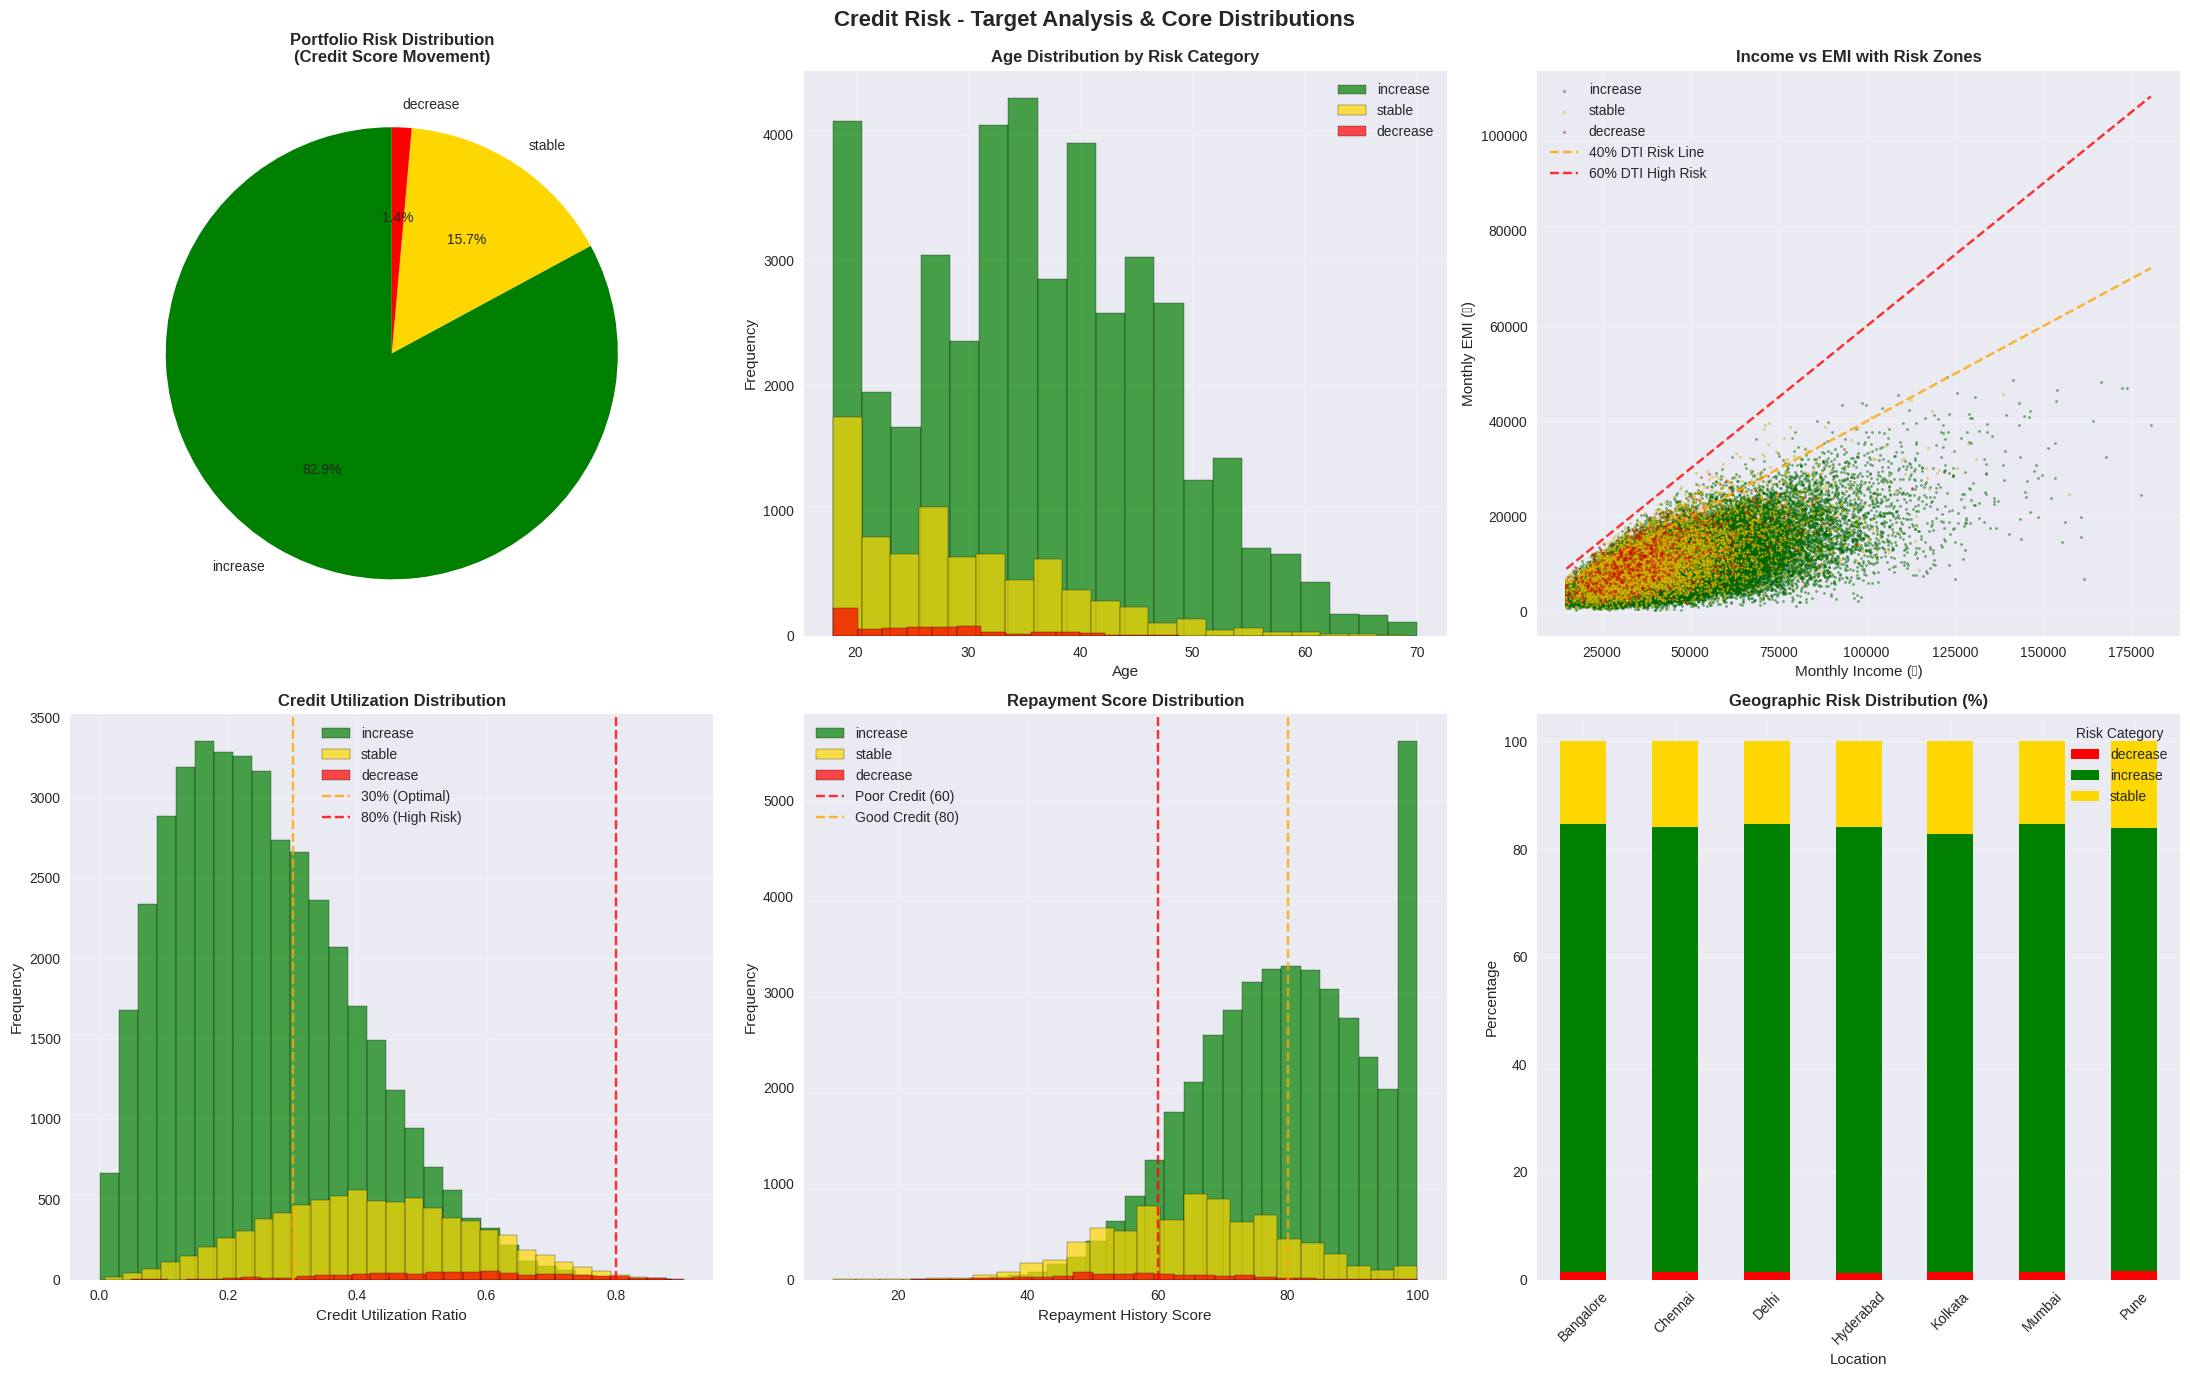

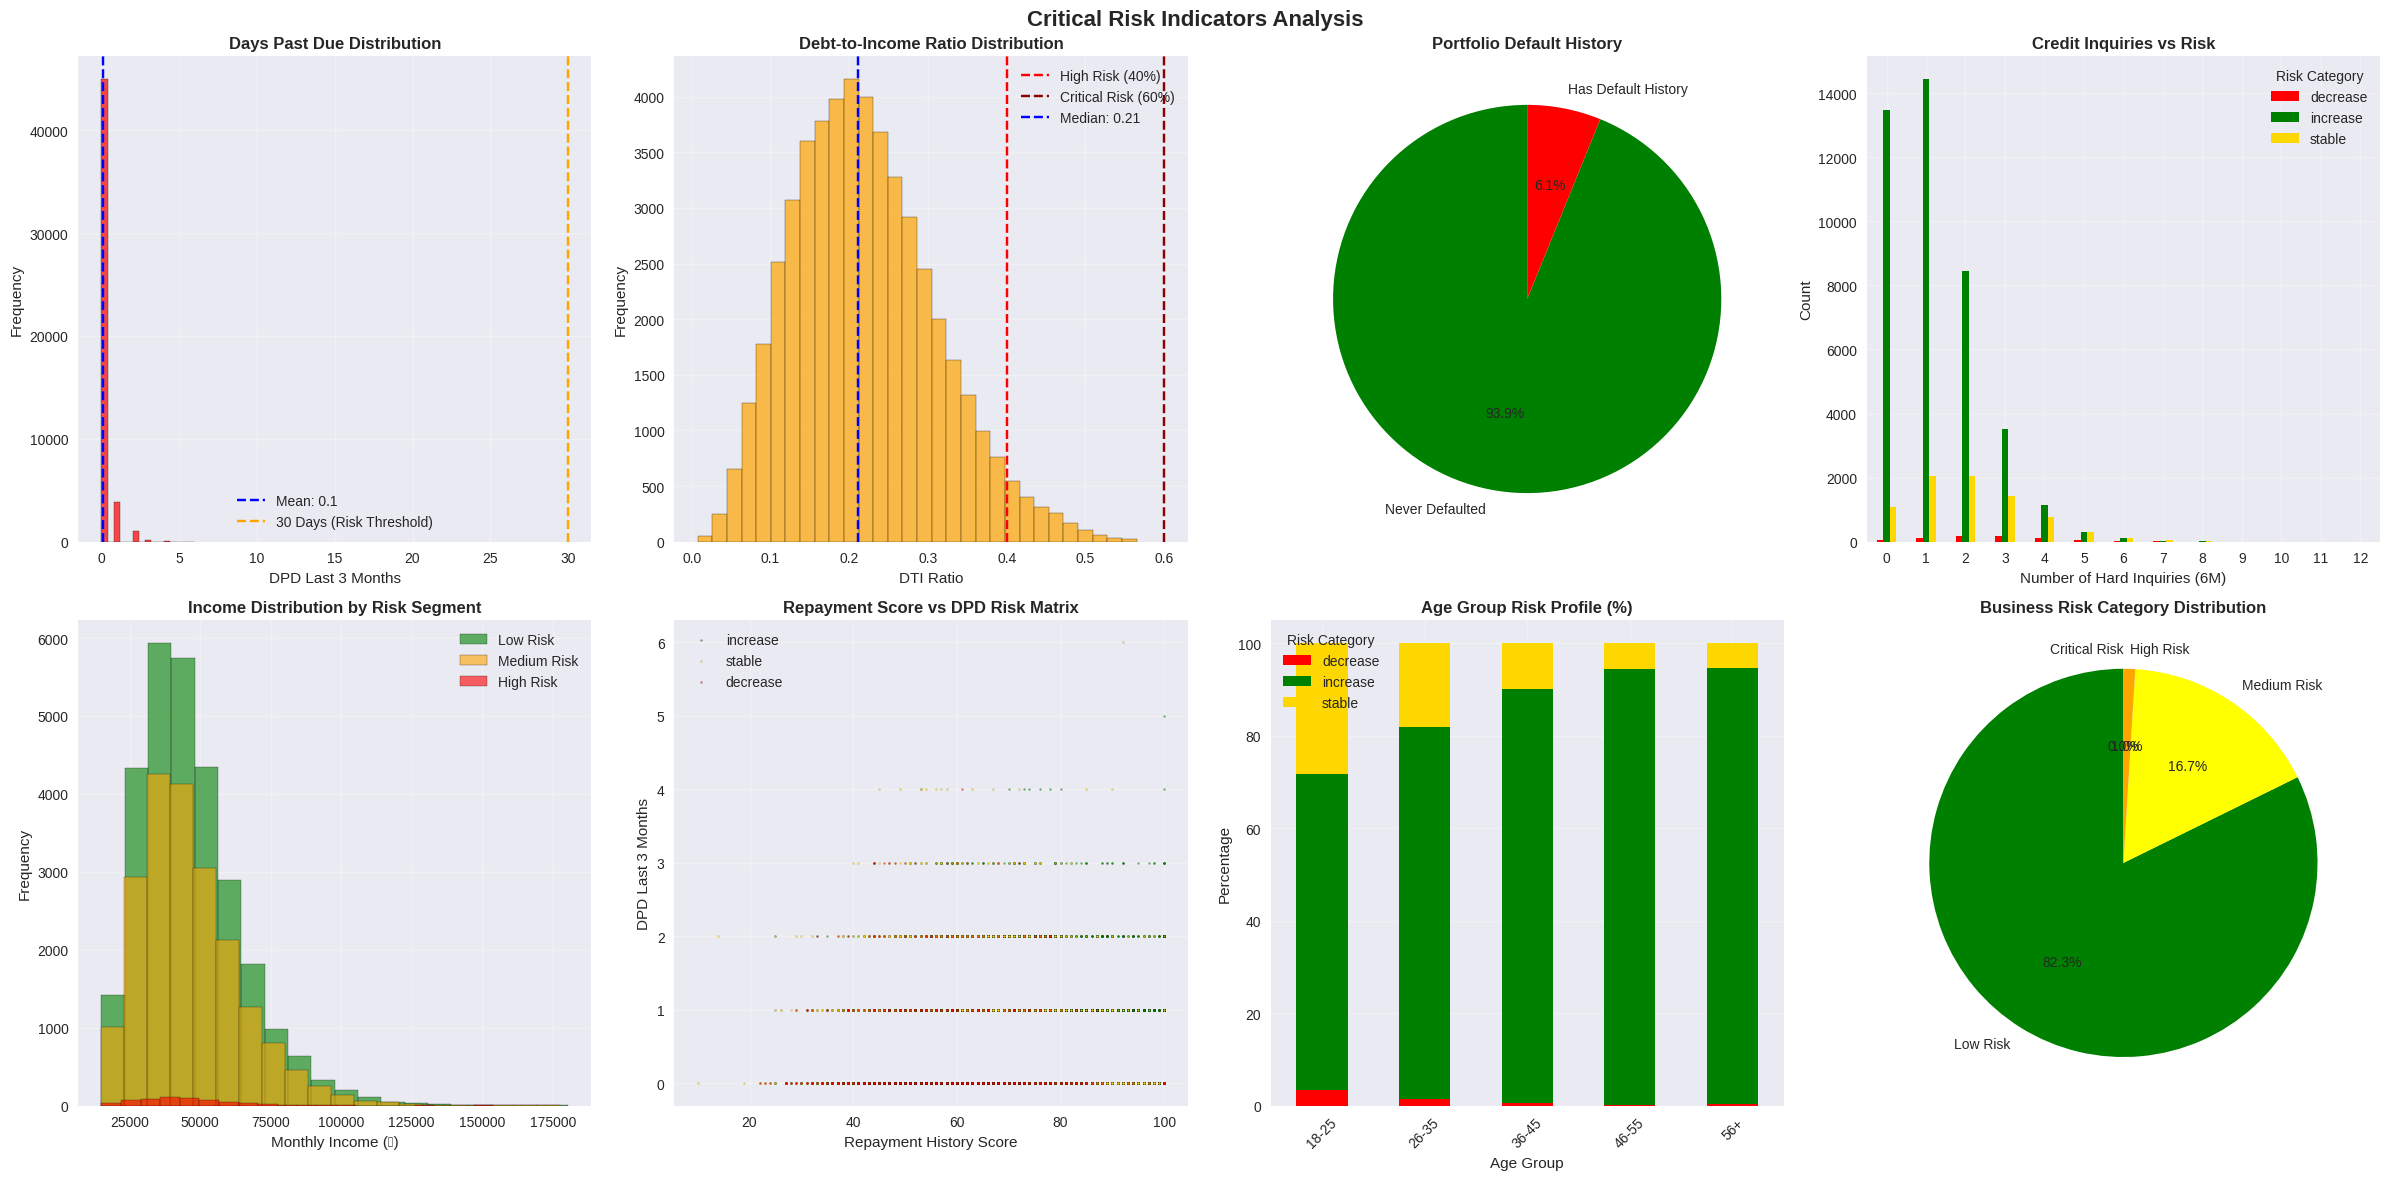


OUTLIER DETECTION ANALYSIS:
----------------------------------------


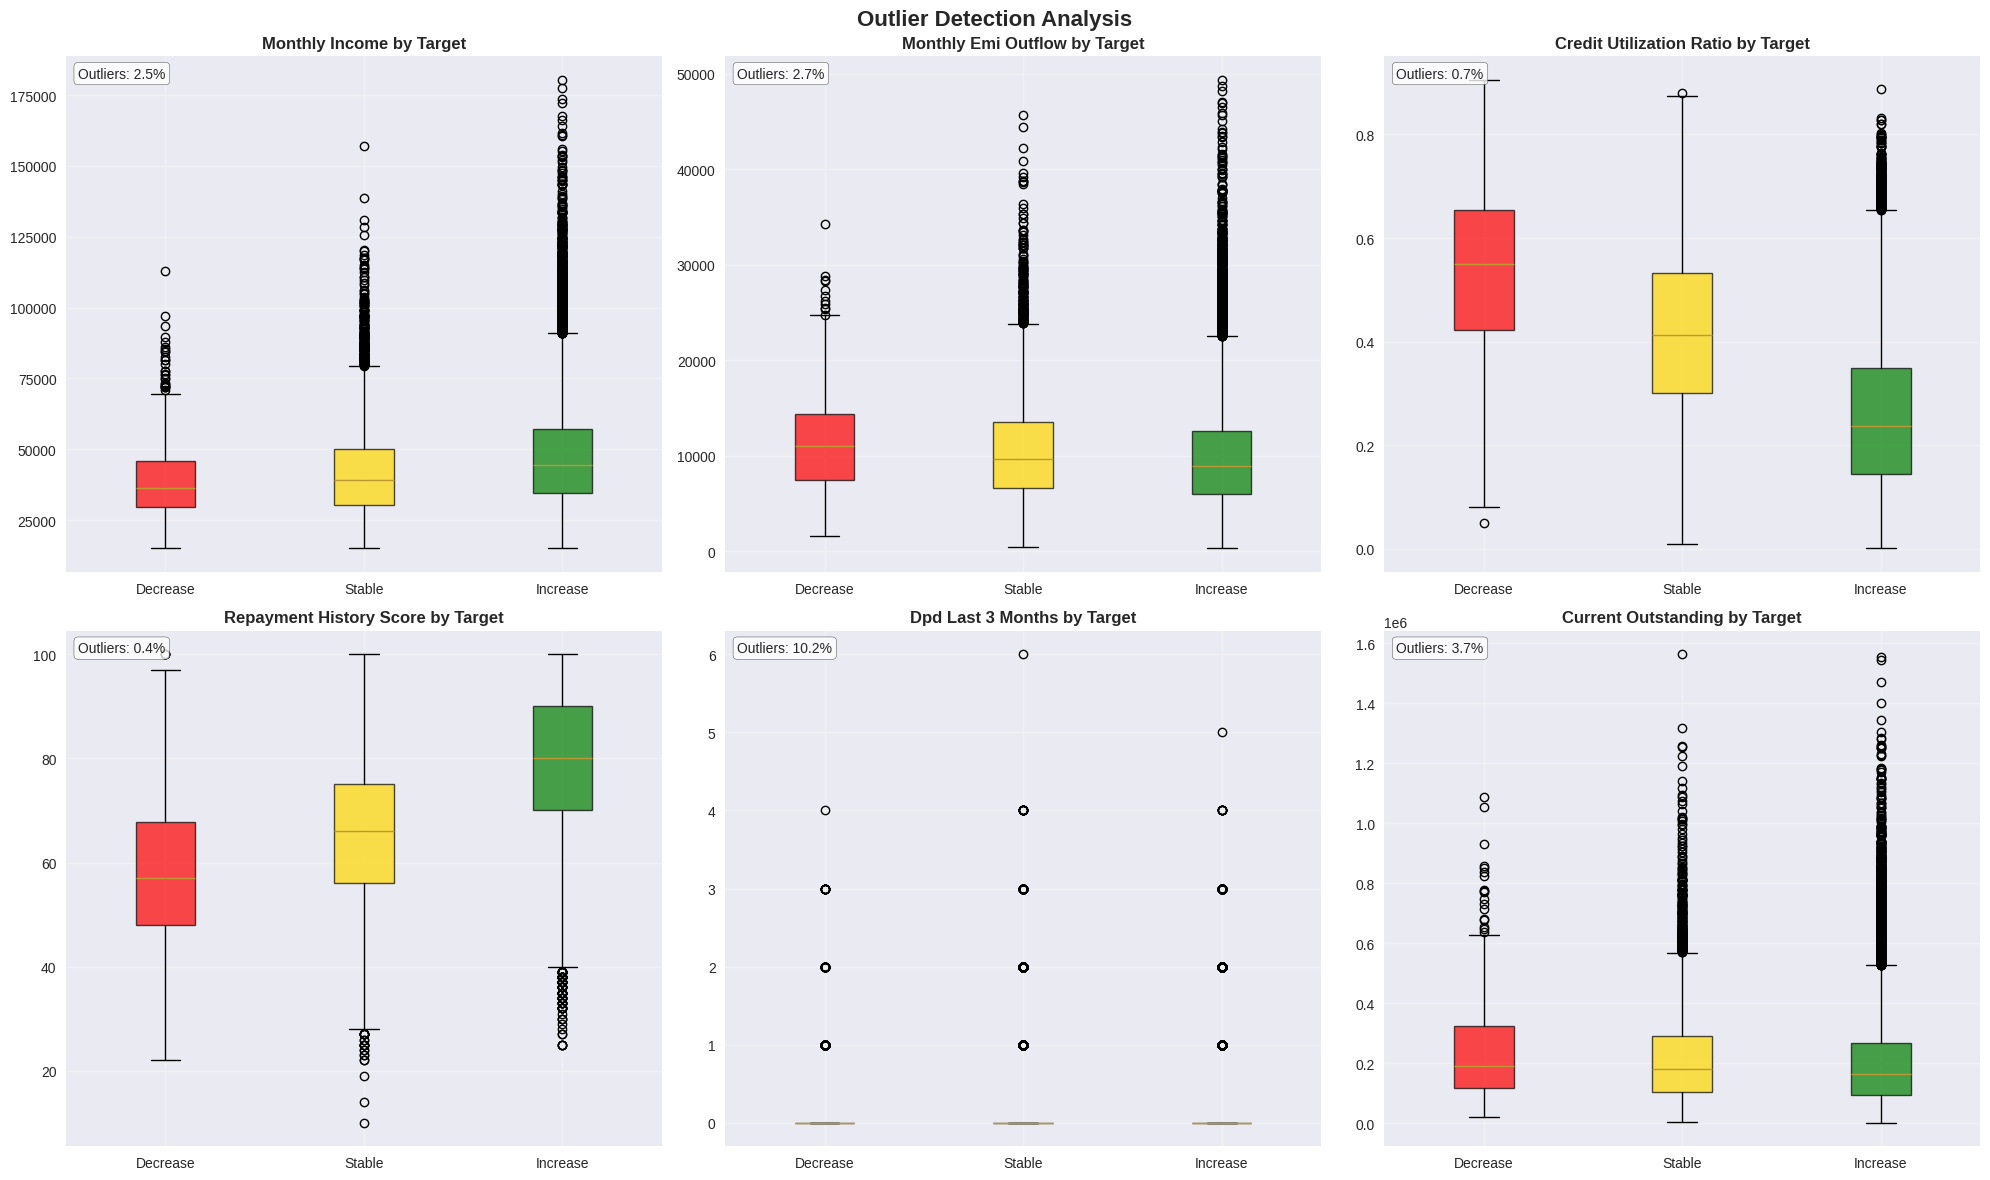


ADVANCED CORRELATION ANALYSIS


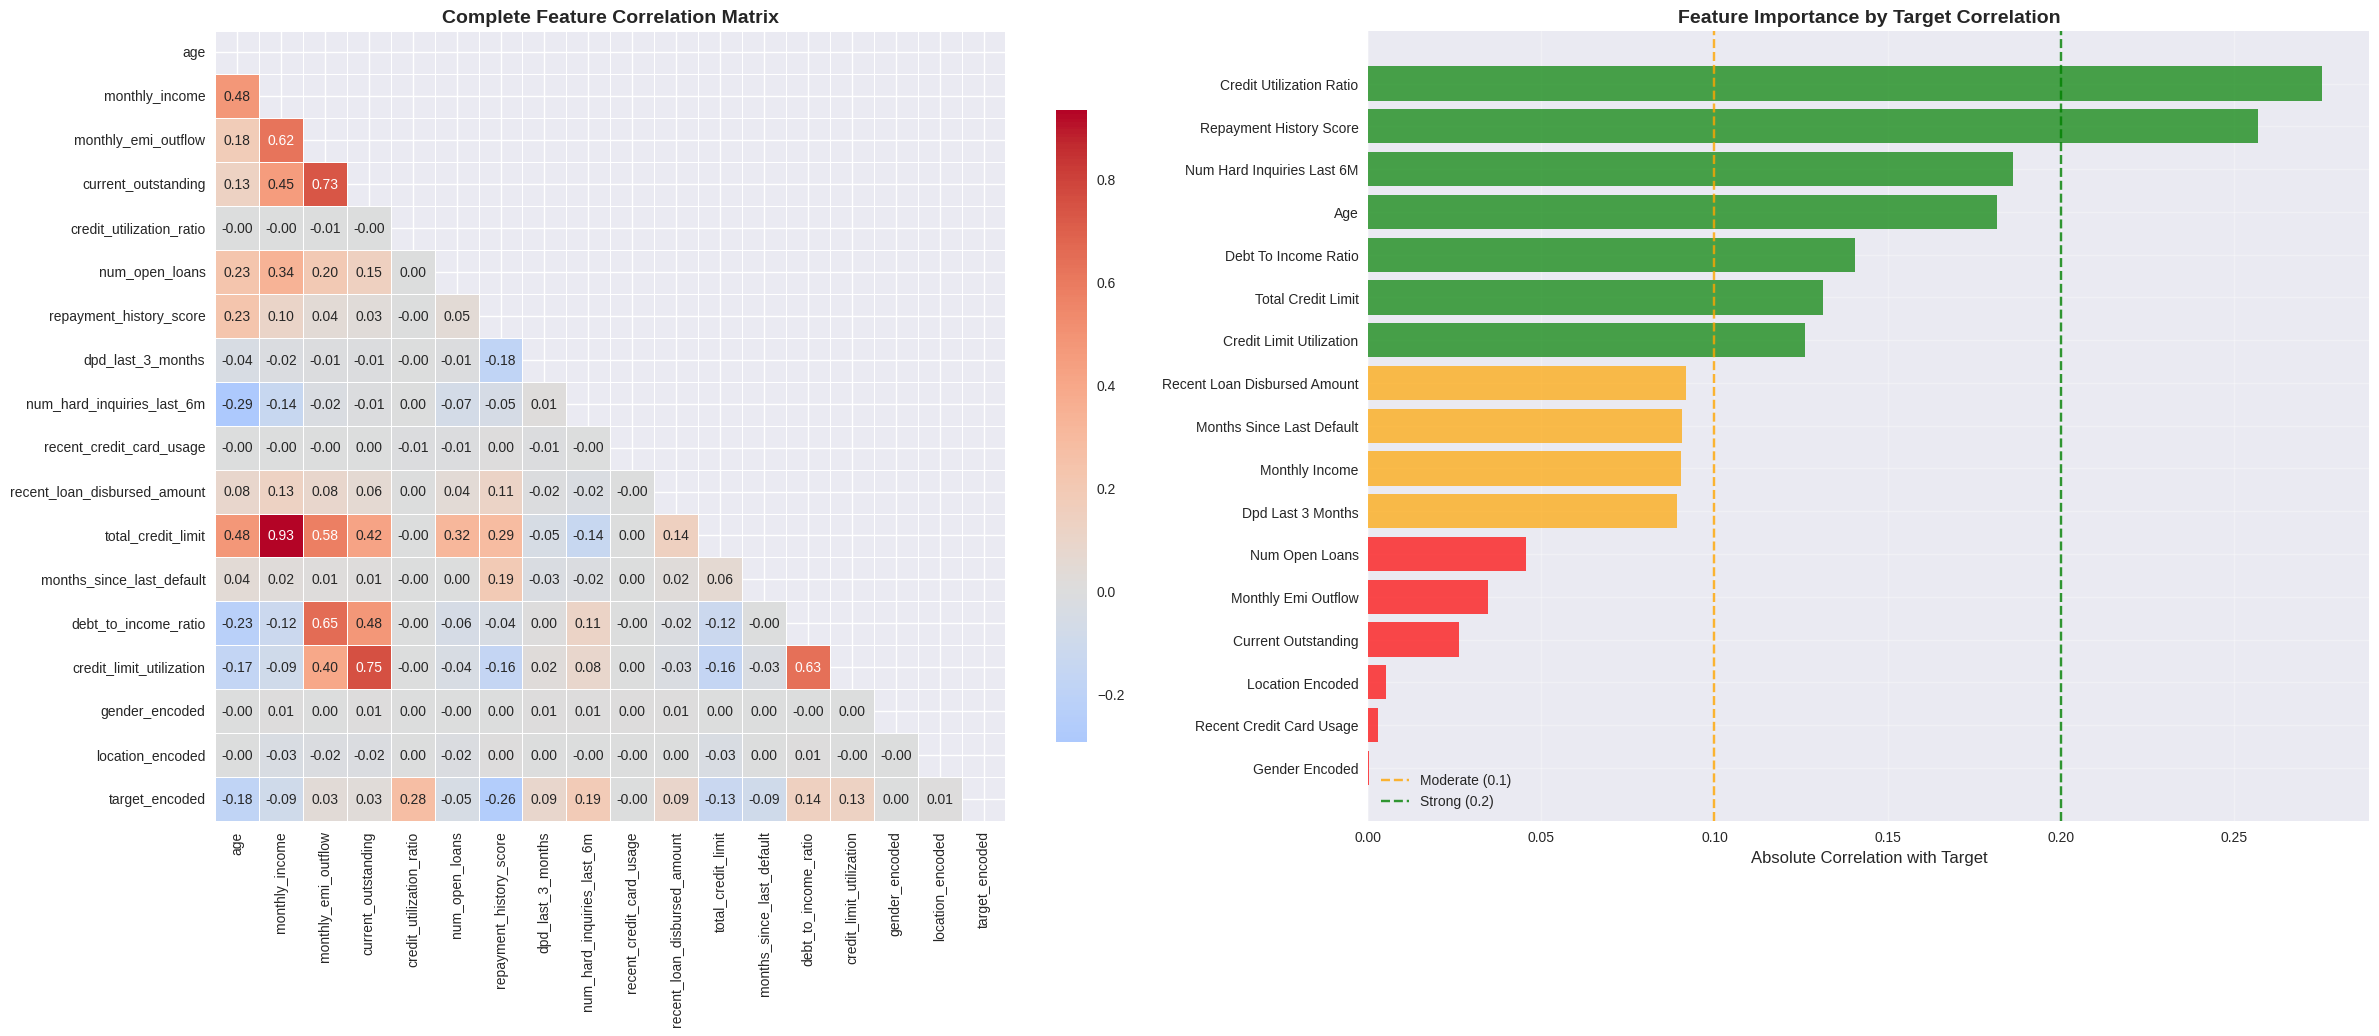

EDA completed successfully!


In [25]:
# Step 2: Comprehensive EDA
print("\nSTEP 2: EXPLORATORY DATA ANALYSIS")
print("="*50)

# Load data if not already in memory
try:
    df.shape
    print("Using dataset from previous cell")
except NameError:
    print("Loading dataset from file...")
    df = pd.read_csv("credit_score_dataset_enhanced.csv")

# Perform comprehensive EDA
perform_comprehensive_eda(df)

print("EDA completed successfully!")

## Create useful features

In [26]:
print("\nSTEP 3: FEATURE ENGINEERING")
print("="*50)

# Load data if needed
try:
    df.shape
    print("Using dataset from previous cells")
except NameError:
    print("Loading dataset from file...")
    df = pd.read_csv("credit_score_dataset_enhanced.csv")

# Feature Engineering
df_engineered = engineer_features(df)

print(f" Feature engineering completed!")
print(f"   -> Original features: {len(df.columns)}")
print(f"   -> Enhanced features: {len(df_engineered.columns)}")
print(f"   -> New features added: {len(df_engineered.columns) - len(df.columns)}")

# Display new features
new_features = [col for col in df_engineered.columns if col not in df.columns]
if new_features:
    print(f"   -> New features: {', '.join(new_features)}")


STEP 3: FEATURE ENGINEERING
Using dataset from previous cells
Engineering complete. Added 6 new features
 Feature engineering completed!
   -> Original features: 17
   -> Enhanced features: 23
   -> New features added: 6
   -> New features: debt_to_income_ratio, credit_limit_utilization, income_bracket, age_group, high_risk_indicator, recent_activity_score


## Data Prepration

In [27]:
print("\nSTEP 4: DATA PREPARATION")
print("="*50)

# Load engineered data if needed
try:
    df_engineered.shape
    print("Using engineered dataset from previous cells")
except NameError:
    print("Engineered dataset not found. Please run Cell 3 first.")
    raise ValueError("Please run Feature Engineering cell first")

# Split features and target
X = df_engineered.drop(columns=["customer_id", "target_credit_score_movement"])
y = df_engineered["target_credit_score_movement"]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Data splitting completed:")
print(f"   -> Training set: {X_train.shape}")
print(f"   -> Test set: {X_test.shape}")
print(f"   -> Training target distribution: {pd.Series(y_train).value_counts().to_dict()}")
print(f"   -> Test target distribution: {pd.Series(y_test).value_counts().to_dict()}")


STEP 4: DATA PREPARATION
Using engineered dataset from previous cells
Features shape: (50009, 21)
Target shape: (50009,)
Data splitting completed:
   -> Training set: (40007, 21)
   -> Test set: (10002, 21)
   -> Training target distribution: {'increase': 33161, 'stable': 6284, 'decrease': 562}
   -> Test target distribution: {'increase': 8291, 'stable': 1571, 'decrease': 140}


## Preprocess

In [28]:
print("\n🔧 STEP 5: ADVANCED PREPROCESSING")
print("="*50)

# Check if train/test data exists
try:
    X_train.shape
    print("Using train/test data from previous cells")
except NameError:
    print("Train/test data not found. Please run Cell 4 first.")
    raise ValueError("Please run Data Preparation cell first")

# Advanced preprocessing
X_train_processed, X_test_processed, preprocessor, feature_names = advanced_preprocessing_pipeline(
    X_train, X_test
)

print(f"Preprocessing completed:")
print(f"   -> Processed training shape: {X_train_processed.shape}")
print(f"   -> Processed test shape: {X_test_processed.shape}")
print(f"   -> Total features after preprocessing: {len(feature_names)}")
print(f"   -> Numeric features: {len(X_train.select_dtypes(include=[np.number]).columns)}")
print(f"   -> Categorical features: {len(X_train.select_dtypes(include=['object', 'category']).columns)}")


🔧 STEP 5: ADVANCED PREPROCESSING
Using train/test data from previous cells
Numeric features (17): ['age', 'monthly_income', 'monthly_emi_outflow', 'current_outstanding', 'credit_utilization_ratio', 'num_open_loans', 'repayment_history_score', 'dpd_last_3_months', 'num_hard_inquiries_last_6m', 'recent_credit_card_usage', 'recent_loan_disbursed_amount', 'total_credit_limit', 'months_since_last_default', 'debt_to_income_ratio', 'credit_limit_utilization', 'high_risk_indicator', 'recent_activity_score']
Categorical features (4): ['gender', 'location', 'income_bracket', 'age_group']
Preprocessing completed:
   -> Processed training shape: (40007, 36)
   -> Processed test shape: (10002, 36)
   -> Total features after preprocessing: 36
   -> Numeric features: 17
   -> Categorical features: 4


## Balance the Dataset

In [29]:
print("\nSTEP 6: HANDLING CLASS IMBALANCE")
print("="*50)

# Check if processed data exists
try:
    X_train_processed.shape
    print("Using processed data from previous cells")
except NameError:
    print("Processed data not found. Please run Cell 5 first.")
    raise ValueError("Please run Preprocessing cell first")

# Handle class imbalance
X_train_balanced, y_train_balanced = handle_class_imbalance(
    X_train_processed, y_train, strategy='smote_tomek'
)

print(f"Class imbalance handling completed:")
print(f"   -> Original training shape: {X_train_processed.shape}")
print(f"   -> Balanced training shape: {X_train_balanced.shape}")
print(f"   -> Sampling ratio: {X_train_balanced.shape[0] / X_train_processed.shape[0]:.2f}x")

# Show class distribution comparison
original_dist = pd.Series(y_train).value_counts()
balanced_dist = pd.Series(y_train_balanced).value_counts()

print(f"\nClass Distribution Comparison:")
for class_name in original_dist.index:
    orig_count = original_dist[class_name]
    bal_count = balanced_dist[class_name]
    print(f"   -> {class_name}: {orig_count} -> {bal_count} ({bal_count/orig_count:.1f}x)")


STEP 6: HANDLING CLASS IMBALANCE
Using processed data from previous cells
Original class distribution:
target_credit_score_movement
increase    33161
stable       6284
decrease      562
Name: count, dtype: int64
Resampled class distribution (smote_tomek):
target_credit_score_movement
decrease    33161
increase    33140
stable      33140
Name: count, dtype: int64
Class imbalance handling completed:
   -> Original training shape: (40007, 36)
   -> Balanced training shape: (99441, 36)
   -> Sampling ratio: 2.49x

Class Distribution Comparison:
   -> increase: 33161 → 33140 (1.0x)
   -> stable: 6284 → 33140 (5.3x)
   -> decrease: 562 → 33161 (59.0x)


## Train

In [34]:
print("\nSTEP 7: ADVANCED MODEL TRAINING & EVALUATION")
print("="*50)

# Check if balanced data exists
try:
    X_train_balanced.shape
    print("Using balanced data from previous cells")
except NameError:
    print("Balanced data not found. Please run Cell 6 first.")
    raise ValueError("Please run Class Imbalance Handling cell first")

# Model training
results, best_models, timing_analysis = train_multiple_models_optimized(
    X_train_balanced, y_train_balanced, X_test_processed, y_test, feature_names
)


print(f"Model training completed:")
print(f"Random Forest took: {results['Random Forest']['timings']['total_model_time']:.2f} seconds")
print(f"Hist Gradient Boosting took: {results['Hist Gradient Boosting']['timings']['total_model_time']:.2f} seconds")
print(f"Logistic Regression took: {results['Logistic Regression']['timings']['total_model_time']:.2f} seconds")
print(f"Fastest model: {timing_analysis['recommendations']['fastest_model']}")
print(f"   -> Models trained: {len(results)}")
print(f"   -> Models available: {list(results.keys())}")

# Quick performance overview
for name, result in results.items():
    print(f"   -> {name}: F1={result['f1_macro']:.4f}, Accuracy={result['accuracy']:.4f}")


STEP 7: ADVANCED MODEL TRAINING & EVALUATION
Using balanced data from previous cells


Hyperparameter Tuning: 100%|██████████| 4/4 [15:55<00:00, 238.77s/combination, Time=955.1s, Best Score=0.9727]
                                                                                                              
Training Hist Gradient Boosting:  33%|███▎      | 1/3 [15:55<31:51, 955.91s/model]


Random Forest Training Completed:
   --> Hyperparameter Tuning: 955.06s
   --> Model Evaluation: 0.83s
   --> Total Training Time: 955.91s
   --> Performance: F1=0.7473, Accuracy=0.9124



Hyperparameter Tuning: 100%|██████████| 7/7 [03:03<00:00, 26.22s/combination, Time=183.6s, Best Score=0.9672]
                                                                                                             
Training Logistic Regression:  67%|██████▋   | 2/3 [19:00<08:22, 502.08s/model]   


Hist Gradient Boosting Training Completed:
   --> Hyperparameter Tuning: 183.56s
   --> Model Evaluation: 0.82s
   --> Total Training Time: 184.40s
   --> Performance: F1=0.7937, Accuracy=0.9226



Hyperparameter Tuning: 100%|██████████| 2/2 [00:24<00:00, 12.22s/combination, Time=24.4s, Best Score=0.9105]
                                                                                                            
Training Logistic Regression: 100%|██████████| 3/3 [19:24<00:00, 388.32s/model]


Logistic Regression Training Completed:
   --> Hyperparameter Tuning: 24.43s
   --> Model Evaluation: 0.21s
   --> Total Training Time: 24.66s
   --> Performance: F1=0.7454, Accuracy=0.8965

COMPREHENSIVE TRAINING TIME ANALYSIS
Training Time Comparison:
                    Model  Hyperparameter_Tuning_Time_(s)  \
2     Logistic Regression                           24.43   
1  Hist Gradient Boosting                          183.56   
0           Random Forest                          955.06   

   Evaluation_Time_(s)  Total_Training_Time_(s)  F1_Score  Accuracy  
2                 0.21                    24.66      0.75      0.90  
1                 0.82                   184.40      0.79      0.92  
0                 0.83                   955.91      0.75      0.91  

Time Efficiency Analysis:
   --> Fastest Model: Logistic Regression (24.66s)
   --> Slowest Model: Random Forest (955.91s)
   --> Speed Difference: 38.8x slower
   --> Total Pipeline Time: 1164.98s

Performance vs Time 

## Evaluate


STEP 8: COMPREHENSIVE EVALUATION
Using model results from previous cells

COMPREHENSIVE MODEL EVALUATION

Model Performance Summary:
                        Accuracy  F1 Macro  F1 Weighted  AUC Macro
Random Forest             0.9124    0.7473       0.9133     0.9710
Hist Gradient Boosting    0.9226    0.7937       0.9230     0.9745
Logistic Regression       0.8965    0.7454       0.9042     0.9730

Random Forest - Detailed Classification Report:
              precision    recall  f1-score   support

    decrease       0.80      0.42      0.55       140
    increase       0.96      0.94      0.95      8291
      stable       0.70      0.79      0.74      1571

    accuracy                           0.91     10002
   macro avg       0.82      0.72      0.75     10002
weighted avg       0.92      0.91      0.91     10002


Hist Gradient Boosting - Detailed Classification Report:
              precision    recall  f1-score   support

    decrease       0.71      0.62      0.66       140
 

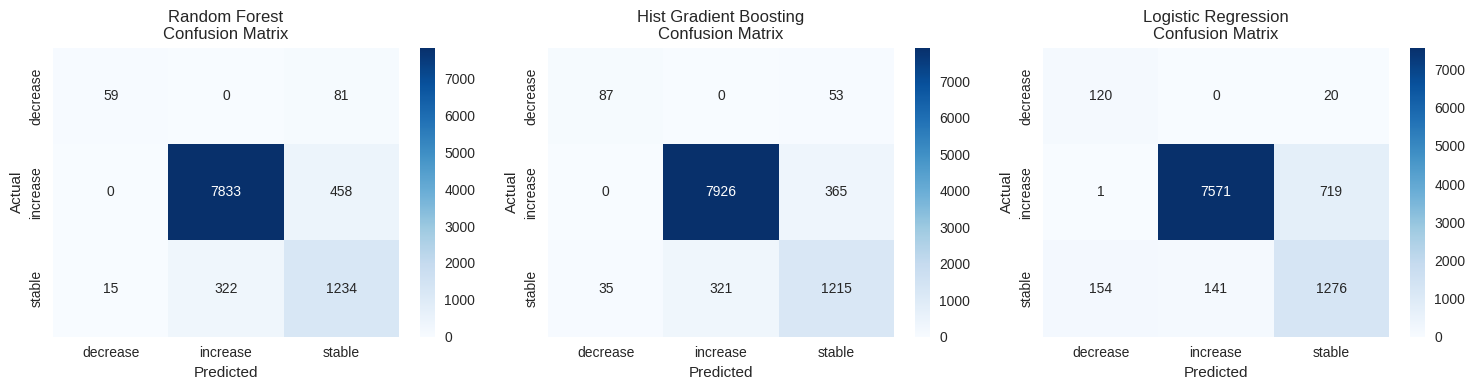

Model evaluation completed:
   -> Evaluation metrics calculated for 3 models
   -> Best model identification completed

MODEL PERFORMANCE SUMMARY:
                        Accuracy  F1 Macro  F1 Weighted  AUC Macro
Random Forest             0.9124    0.7473       0.9133     0.9710
Hist Gradient Boosting    0.9226    0.7937       0.9230     0.9745
Logistic Regression       0.8965    0.7454       0.9042     0.9730


In [35]:
print("\nSTEP 8: COMPREHENSIVE EVALUATION")
print("="*50)

# Check if results exist
try:
    len(results)
    print("Using model results from previous cells")
except NameError:
    print("Model results not found. Please run Cell 7 first.")
    raise ValueError("Please run Model Training cell first")

# Comprehensive evaluation
class_names = ['decrease', 'increase', 'stable']
summary_df = comprehensive_evaluation(results, y_test, class_names)

print(f"Model evaluation completed:")
print(f"   -> Evaluation metrics calculated for {len(results)} models")
print(f"   -> Best model identification completed")

# Display summary
print(f"\nMODEL PERFORMANCE SUMMARY:")
print(summary_df.round(4))

## SHAP for model interpretability


STEP 9: MODEL INTERPRETABILITY (SHAP)
Using evaluation results from previous cells
Best performing model: Hist Gradient Boosting
   -> F1 Score: 0.7937
   -> Accuracy: 0.9226

SHAP ANALYSIS FOR HIST GRADIENT BOOSTING
Initial feature_names length: 36
X_test shape: (10002, 36)
Using TreeExplainer...
Computing SHAP values for 100 samples...
SHAP values shape: (100, 36, 3)
Actual features from SHAP: 36
Adjusted feature names length: 36


<Figure size 1000x600 with 0 Axes>

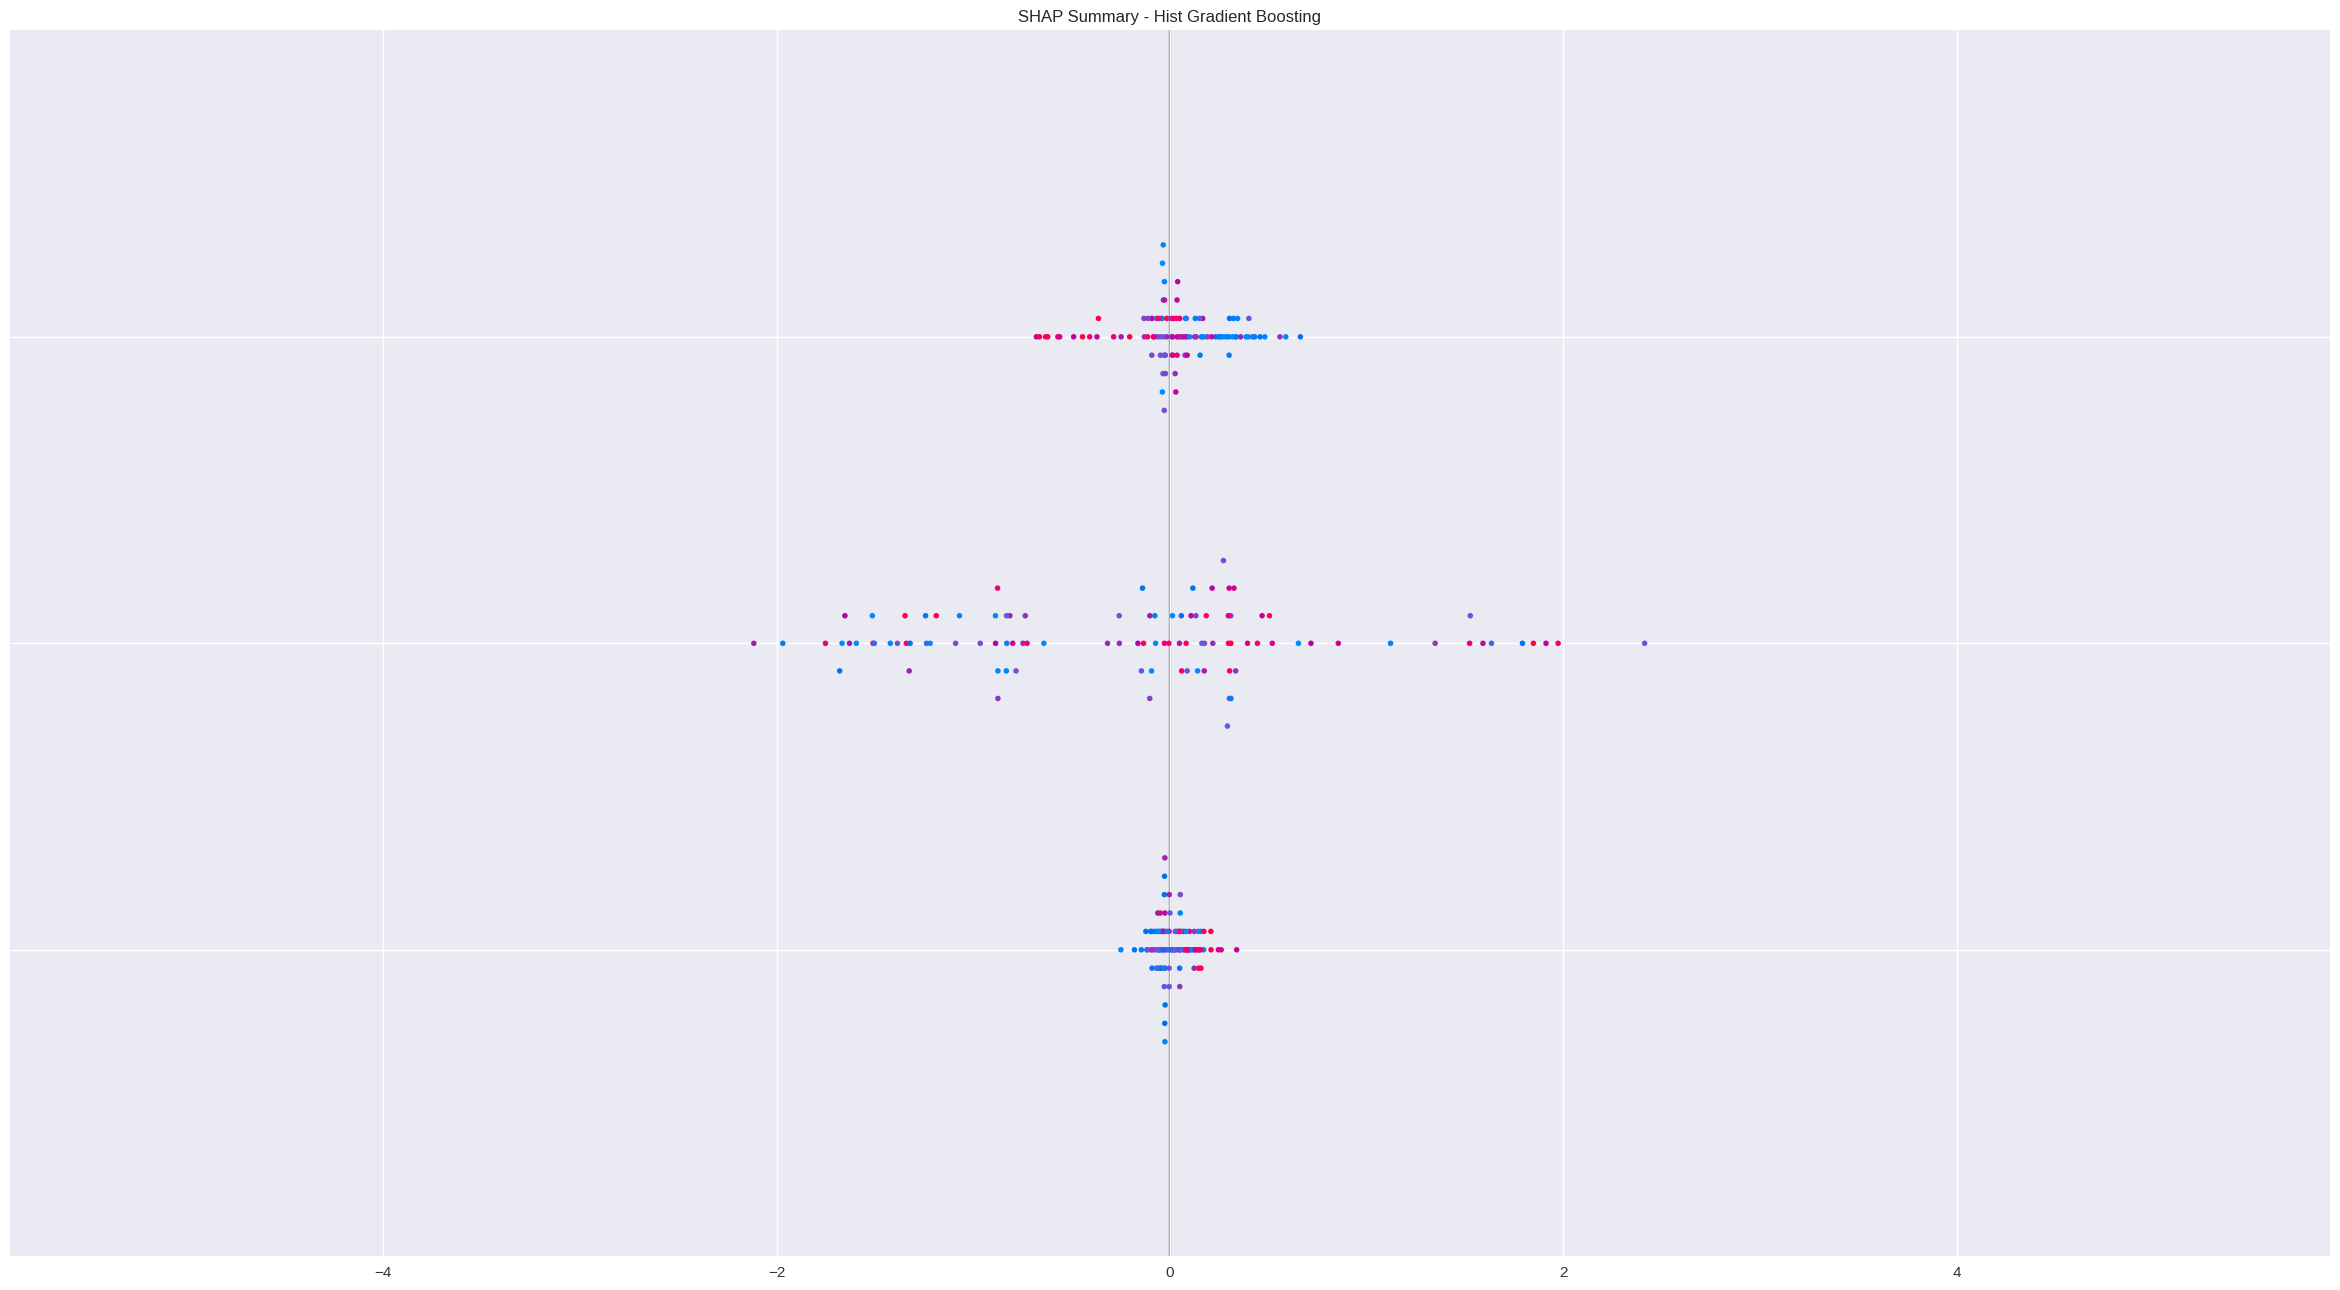

Final lengths - Features: 36, Importance: 36

 Successfully created feature importance DataFrame
Top 10 Most Important Features:
                      feature  importance
12  months_since_last_default    2.560102
18                   gender_M    2.501805
13       debt_to_income_ratio    2.300390
19               gender_Other    1.990206
14   credit_limit_utilization    0.772638
20         location_Bangalore    0.589292
16      recent_activity_score    0.512296
30   income_bracket_Very High    0.451535
6     repayment_history_score    0.388093
1              monthly_income    0.380482


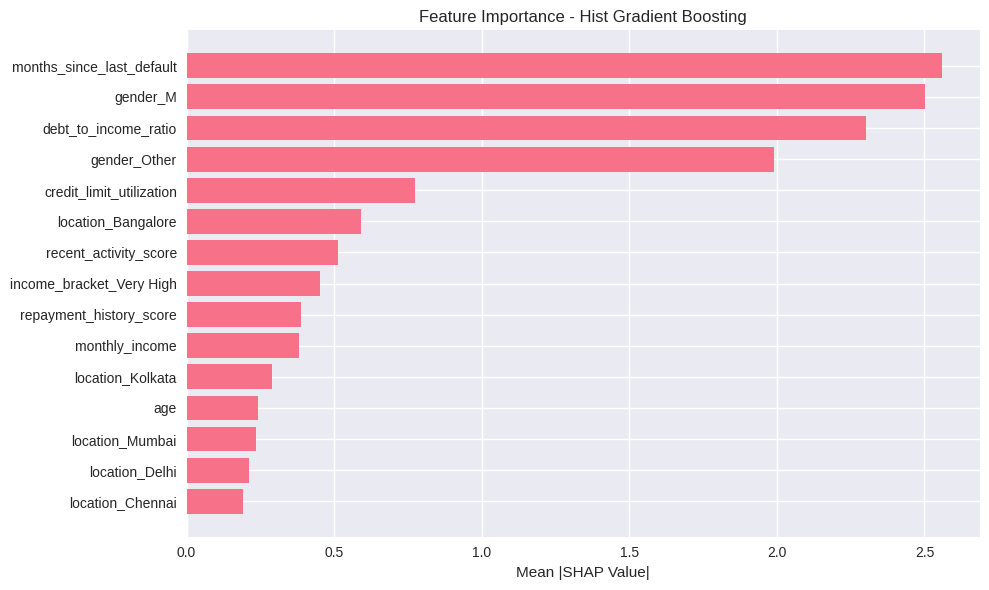

SHAP analysis completed successfully


In [36]:
print("\nSTEP 9: MODEL INTERPRETABILITY (SHAP)")
print("="*50)

# Check if evaluation results exist
try:
    summary_df.shape
    print("Using evaluation results from previous cells")
except NameError:
    print("Evaluation results not found. Please run Cell 8 first.")
    raise ValueError("Please run Model Evaluation cell first")

# Select best model and perform SHAP analysis
best_model_name = summary_df['F1 Macro'].idxmax()
best_model = results[best_model_name]['model']

print(f"Best performing model: {best_model_name}")
print(f"   -> F1 Score: {summary_df.loc[best_model_name, 'F1 Macro']:.4f}")
print(f"   -> Accuracy: {summary_df.loc[best_model_name, 'Accuracy']:.4f}")

# SHAP analysis with error handling
try:
    feature_importance_df = shap_analysis(
        best_model, X_test_processed, feature_names, best_model_name
    )
    print("SHAP analysis completed successfully")
except Exception as e:
    print(f"SHAP analysis encountered issues: {e}")
    print("Creating fallback feature importance...")

    # Fallback feature importance
    if hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
    else:
        importances = np.abs(best_model.coef_).mean(0)

    feature_importance_df = pd.DataFrame({
        'feature': feature_names[:len(importances)],
        'importance': importances[:len(feature_names)]
    }).sort_values('importance', ascending=False)

    print("Fallback feature importance created")

## Business insights

In [37]:
print("\nSTEP 10: BUSINESS INSIGHTS & STRATEGY")
print("="*50)

# Check if required data exists
required_vars = ['best_model', 'feature_importance_df', 'df_engineered']
missing_vars = []

for var in required_vars:
    try:
        eval(var)
    except NameError:
        missing_vars.append(var)

if missing_vars:
    print(f"Missing variables: {', '.join(missing_vars)}")
    print("Loading from previous cells or creating fallbacks...")

    # Load engineered dataset if missing
    if 'df_engineered' in missing_vars:
        try:
            df_engineered = df.copy()  # Use original if engineered not available
            df_engineered = engineer_features(df_engineered)
        except:
            print("Using original dataset for business analysis")
            df_engineered = df

# Business insights analysis
business_insights_analysis(best_model, feature_importance_df, df_engineered)

print("Business insights analysis completed!")


STEP 10: BUSINESS INSIGHTS & STRATEGY

BUSINESS INSIGHTS & RECOMMENDATIONS
   DEBUG: DataFrame Analysis
   Shape: (36, 2)
   Columns: ['feature', 'importance']
   Empty: False
Successfully extracted 5 top features

 HIGH-RISK SEGMENT ANALYSIS:
----------------------------------------
-> High DPD: 0.0% of high-risk customers
-> High Credit Utilization: 4.3% of high-risk customers
-> Recent Hard Inquiries: 30.6% of high-risk customers
-> Low Repayment Score: 56.4% of high-risk customers

 HIGH-OPPORTUNITY SEGMENT ANALYSIS:
----------------------------------------
-> Low Credit Utilization: 64.8% of high-opportunity customers
-> High Repayment Score: 48.4% of high-opportunity customers
-> No Recent Defaults: 95.5% of high-opportunity customers
-> Stable Income: 37.7% of high-opportunity customers

 STRATEGIC RECOMMENDATIONS:
----------------------------------------
1. RISK MITIGATION STRATEGIES:
   -> Implement EMI restructuring for customers with high DPD + high utilization
   -> Create